### make_pitstop_dataset-nextpit

base: 17./ make_pitstop_dataset-nextpit

build a pitstop dataset with <cautions_laps, pitage, gap2nextpit>
gluonts interface of Dataset = Iterable[DataEntry], DataEntry = Dict(str, any)

+ input pitstop dataset, remove pitstops with pit_oncaution = 1, refer to lapstatus_dataset-fastrun
+ context_length = 1, prediction_length = 1
+ target : gap to nextpit
+ covariates are: cautions_laps, pitage, (carid, eid)
+ modeling the distribution of nextpit-gap


In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os,sys
import random
import mxnet as mx
from mxnet import gluon
import pickle
import json
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import inspect
from scipy import stats
from pathlib import Path 
from sklearn.metrics import mean_squared_error
from gluonts.dataset.util import to_pandas
from pathlib import Path
from gluonts.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator, MultivariateEvaluator
from gluonts.model.predictor import Predictor
from gluonts.distribution.neg_binomial import NegativeBinomialOutput
from gluonts.distribution.student_t import StudentTOutput
from gluonts.model.forecast import SampleForecast

from indycar.model.mlp import MLPEstimator

INFO:root:Using GPU


In [2]:
import os
os.getcwd()

'/scratch_hdd/hpda/indycar/notebook/18.FinalTest'

In [3]:

def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

def test_flag(a, bitflag):
    return (a & bitflag) ==  bitflag

#
# remove NaN at the tail
# there should be no nans in the middle of the ts
COL_LAPTIME=0
COL_RANK=1
COL_TRACKSTATUS=2
COL_LAPSTATUS=3
COL_TIMEDIFF=4
COL_CAUTION_LAPS_INSTINT=5
COL_LAPS_INSTINT= 6
COL_ELAPSED_TIME= 7
COL_LAP2NEXTPIT = 8


MODE_ORACLE = 0
MODE_NOLAP = 1
MODE_NOTRACK = 2
MODE_TESTZERO = 4
MODE_TESTCURTRACK = 8
#MODE_STR={MODE_ORACLE:'oracle', MODE_NOLAP:'nolap',MODE_NOTRACK:'notrack',MODE_TEST:'test'}

def split_ts(rec, carno, eid):
    """
    input: 
        ts
    output:
        nextpit records
    """
    output = []
    pitstops = np.where(rec[COL_LAPSTATUS,:] == 1)[0]
    
    if len(pitstops)==0:
        print('no pit ts')
        return output
    
    #pit_oncaution = np.zeros_like((pitstops))
    #for pit in pitstops:
    #    if rec[COL_TRACKSTATUS,:] == 1:
    #        pit_oncaution = 1
    pit_oncaution = np.zeros_like((rec[COL_LAP2NEXTPIT,:]))
    stint_len = np.zeros_like((rec[COL_LAP2NEXTPIT,:]))
    pos = 0
    for pit in pitstops:
        if rec[COL_TRACKSTATUS,pit] == 1:
            #next pit is oncaution
            # set pos -> pit as oncaution
            pit_oncaution[pos:pit] = 1
        else:
            pit_oncaution[pos:pit] = 0
            
        stint_len[pos:pit] = pit - pos
        pos = pit
        
            
    #prepare output : lap2nextpit, CAUTION_LAPS_INSTINT,LAPS_INSTINT, pit_oncaution, carno, eid, lap, stintlen
    totallen = pitstops[-1]
    #output = np.zeros((totallen, 6 ))
    #for idx in range(totallen):
    #    output[idx, 0] = rec[COL_LAP2NEXTPIT ,idx]
    #    output[idx, 1] = rec[COL_CAUTION_LAPS_INSTINT ,idx]
    #    output[idx, 2] = rec[COL_LAPS_INSTINT ,idx]
    #    output[idx, 3] = pit_oncaution[idx]
    #    output[idx, 4] = carno
    #    output[idx, 5] = eid
        
    for idx in range(totallen):
        output.append([ rec[COL_LAP2NEXTPIT ,idx]
                        ,rec[COL_CAUTION_LAPS_INSTINT ,idx]
                        ,rec[COL_LAPS_INSTINT ,idx]
                        ,pit_oncaution[idx]
                        ,carno
                        ,eid
                        ,idx
                        ,stint_len[idx]
                      ])
        
    return output

def make_dataset_byevent(test_event = 'Indy500-2018'):
    """
    split the ts to train and test part by the ratio
    
    oracle_mode: false to simulate prediction in real by 
        set the covariates of track and lap status as nan in the testset
            
    
    """    
    useeid = False
    run_ts = COL_LAP2NEXTPIT
    train_set = []
    test_set = []
    
    #_data: eventid, carids, datalist[carnumbers, features, lapnumber]->[laptime, rank, track, lap]]
    for _data in laptime_data:
        _train = []
        _test = []
        
        if events[_data[0]] == test_event:
            test_mode = True
        else:
            test_mode = False
            
        # process for each ts
        for rowid in range(_data[2].shape[0]):
            # rec[features, lapnumber] -> [laptime, rank, track_status, lap_status,timediff]]
            rec = _data[2][rowid].copy()
            
            #remove nan(only tails)
            nans, x= nan_helper(rec[run_ts,:])
            nan_count = np.sum(nans)             
            rec = rec[:, ~np.isnan(rec[run_ts,:])]
            
            # remove short ts
            totallen = rec.shape[1]
            
            carno = _data[1][rowid]
            carid = global_carids[_data[1][rowid]]
            
            eid = _data[0]
            
            # all go to train set
            output = split_ts(rec, carno, eid)
            #if len(output) == 0:
            #    continue
            
            test_rec_cnt = 0
            if not test_mode:
                _train.extend(output)
                
            else:
                _test.extend(output)
                test_rec_cnt += 1
            
            #add one ts
            print(f'carno:{carno}, totallen:{totallen}, nancount:{nan_count}, test_reccnt:{test_rec_cnt}')

        train_set.extend(_train)
        test_set.extend(_test)

    print(f'train len:{len(train_set)}, test len:{len(test_set)}')
    
    return train_set, test_set

def save_dataset(datafile,freq, prediction_length, cardinality, train_ds, test_ds):
    with open(datafile, 'wb') as f:
        #pack [global_carids, laptime_data]
        savedata = [freq, prediction_length, cardinality, train_ds, test_ds]
        #savedata = [freq, train_set, test_set]
        # Pickle the 'data' dictionary using the highest protocol available.
        pickle.dump(savedata, f, pickle.HIGHEST_PROTOCOL)

### create dbs

In [4]:
#years = ['2013','2014','2015','2016','2017','2018','2019']
years = ['2013','2014','2015','2016','2017','2018','2019']
#events = ['Indy500']
events = [f'Indy500-{x}' for x in years]
events_id={key:idx for idx, key in enumerate(events)}
dbid = f'Indy500_{years[0]}_{years[-1]}_v9'
testevent = 'Indy500-2018'
# start from here
import pickle
#with open('laptime_rank_timediff_fulltest-oracle-%s.pickle'%year, 'rb') as f:
with open(f'laptime_rank_timediff_pit-oracle-{dbid}.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    global_carids, laptime_data = pickle.load(f, encoding='latin1') 

In [5]:
train, test =  make_dataset_byevent(test_event = 'Indy500-2018')
#prepare output : lap2nextpit, CAUTION_LAPS_INSTINT,LAPS_INSTINT, pit_oncaution, carno, eid, lap
df_train = pd.DataFrame(train,columns=['lap2nextpit', 'caution_laps','pitage', 'pit_oncaution', 
                 'carno','eid','lap','stint_len'])
df_test = pd.DataFrame(test,columns=['lap2nextpit', 'caution_laps','pitage', 'pit_oncaution', 
                 'carno','eid','lap','stint_len'])



carno:1, totallen:200, nancount:0, test_reccnt:0
carno:2, totallen:200, nancount:0, test_reccnt:0
carno:3, totallen:200, nancount:0, test_reccnt:0
no pit ts
carno:4, totallen:0, nancount:200, test_reccnt:0
carno:5, totallen:200, nancount:0, test_reccnt:0
no pit ts
carno:6, totallen:30, nancount:170, test_reccnt:0
carno:7, totallen:177, nancount:23, test_reccnt:0
carno:8, totallen:200, nancount:0, test_reccnt:0
carno:9, totallen:200, nancount:0, test_reccnt:0
carno:10, totallen:187, nancount:13, test_reccnt:0
carno:11, totallen:200, nancount:0, test_reccnt:0
carno:12, totallen:200, nancount:0, test_reccnt:0
carno:14, totallen:200, nancount:0, test_reccnt:0
carno:15, totallen:170, nancount:30, test_reccnt:0
carno:16, totallen:179, nancount:21, test_reccnt:0
carno:18, totallen:200, nancount:0, test_reccnt:0
carno:19, totallen:200, nancount:0, test_reccnt:0
carno:20, totallen:200, nancount:0, test_reccnt:0
carno:21, totallen:170, nancount:30, test_reccnt:0
carno:22, totallen:200, nancount:

In [6]:
datafile = f'pitstop_nextpit_dataset-{dbid}-t{testevent}.pickle'
with open(datafile, 'wb') as f:
    savedata = [df_train, df_test, events, testevent]
    pickle.dump(savedata, f, pickle.HIGHEST_PROTOCOL)

In [7]:
df_train

,lap2nextpit,caution_laps,pitage,pit_oncaution,carno,eid,lap,stint_len
0,30.0,0.0,1.0,0.0,1,0,0,30.0
1,29.0,0.0,2.0,0.0,1,0,1,30.0
2,28.0,0.0,3.0,0.0,1,0,2,30.0
3,27.0,1.0,4.0,0.0,1,0,3,30.0
4,26.0,2.0,5.0,0.0,1,0,4,30.0
...,...,...,...,...,...,...,...,...
30279,2.0,0.0,0.0,1.0,98,6,174,2.0
30280,1.0,1.0,1.0,1.0,98,6,175,2.0
30281,2.0,0.0,0.0,1.0,98,6,176,2.0
30282,1.0,1.0,1.0,1.0,98,6,177,2.0


In [8]:
#make gluonts
from sklearn.preprocessing import StandardScaler,MinMaxScaler

def makedb(data, scaler='standard', perm = True):
    db = []
    start = pd.Timestamp("01-01-2019", freq='1min')  # can be different for each time series
    
    scalers = {'minmax':MinMaxScaler(), 'standard':StandardScaler()}
    
    if isinstance(scaler, str):
        if scaler in scalers:
            scaler = scalers[scaler]
            scaler.fit(data)
            df = scaler.transform(data)
        else:
            # no scaler
            df = data
    else:
        #use input scaler
        #scaler.fit(data)
        df = scaler.transform(data)
        
    
    #permute
    if perm:
        perm = np.random.permutation(len(df))
        df = df[perm]
    
    for x in df:
        
        #db.append({'target':np.array(x[0]), 'feat':[np.array(x[1]),np.array(x[2])]})
        db.append({'target':np.array([x[0]]), 'feat':np.array([x[1],x[2]]),
                  "start":start, 'forecast_start':start})
        #db.append({'target':np.array(x[0]).reshape((1,-1)), 'feat':[np.array(x[1]).reshape((1,-1)),np.array(x[2]).reshape((1,-1))]})
        
    return db, scaler, df


In [39]:
def make_fulltestdb(scaler, maxgap=60):
    db = []
    start = pd.Timestamp("01-01-2019", freq='1min')  # can be different for each time series

    data = []
    for caution_lap in range(maxgap):
        for pitage in range(caution_lap, maxgap):
            data.append([0.,caution_lap, pitage ])
    data = np.array(data)
    
    if not isinstance(scaler, str):
        df = scaler.transform(data)
    else:
        df = data
    
    #data
    print(f'make full testdb: {len(df)} records')
    for x in df:
        db.append({'target':np.array([x[0]]), 'feat':np.array([x[1],x[2]]),
                  "start":start, 'forecast_start':start})
            
    return db, scaler, df, data

In [10]:
train_sel = df_train[(df_train['pit_oncaution']==0) &(df_train['stint_len']>23)]
train_sel_2013_2017 = train_sel[train_sel['eid']<5]
train_all_2013_2017 = df_train[df_train['eid']<5]

print(len(train_all_2013_2017), len(train_sel_2013_2017))    

test_sel = df_test[(df_test['pit_oncaution']==0) &(df_test['stint_len']>23)]
test_all = df_test

#test_all = df_test[(df_test['stint_len']>23)]
#datafile = f'pitstop_nextpit_dataset-{dbid}-t{testevent}-sel.pickle'
#with open(datafile, 'wb') as f:
#    savedata = [train_sel, test_sel, events, testevent]
#    pickle.dump(savedata, f, pickle.HIGHEST_PROTOCOL)
#    
#print(len(train_sel), len(test_sel))    

24973 13976


In [11]:
_data = {}
#model store
p, t, s, e = {}, {} ,{}, {}

# negbin, use no sclaer
#train_ds, scaler = makedb(train_sel[['lap2nextpit','caution_laps','pitage']].values, scaler='')
#train_ds, scaler = makedb(train_sel[['lap2nextpit','caution_laps','pitage']].values, scaler='minmax')
train_ds, scaler, train_set = makedb(train_sel[['lap2nextpit','caution_laps','pitage']].values, scaler='standard')
test_ds, _, test_set = makedb(test_sel[['lap2nextpit','caution_laps','pitage']].values, scaler, perm=False)

# selected db
trainset = train_sel_2013_2017[['lap2nextpit','caution_laps','pitage']].values
testset = test_sel[['lap2nextpit','caution_laps','pitage']].values
train_ds, scaler, _ = makedb(trainset, scaler='standard')
test_ds, _, _ = makedb(testset, scaler, perm=False)

_data['sel'] = [trainset, testset, train_ds, test_ds, scaler]


# selected db
trainset = train_all_2013_2017[['lap2nextpit','caution_laps','pitage']].values
testset = test_all[['lap2nextpit','caution_laps','pitage']].values
train_ds, scaler, _ = makedb(trainset, scaler='standard')
test_ds, _, _ = makedb(testset, scaler, perm=False)

_data['all'] = [trainset, testset, train_ds, test_ds, scaler]


### train

In [17]:
def train_model(epochs, layers=[10,10,5], output = 'student', dropout = .5, id='all'):
    distr_outputs ={'student':StudentTOutput(),  
                    'negbin':NegativeBinomialOutput() 
                   }
    if not output in distr_outputs:
        print(f'distr_output: {output} not found error.')
        return
    
    distr_output = distr_outputs[output]
    
    modelid = 'mlp-d%s-e%s-l%s-%s-d%s'%(id, epochs, '-'.join([str(x) for x in layers]), output, dropout)
    
    estimator = MLPEstimator(
        num_hidden_dimensions=layers,
        prediction_length=1,
        context_length=1,
        freq='1min',
        dropout = dropout,
        distr_output = distr_output,
        trainer=Trainer(ctx="gpu(0)", 
                        batch_size = 32,
                        epochs= epochs,
                        learning_rate=1e-3,
                        hybridize=False,
                        num_batches_per_epoch=100
                       )
    )    

    predictor = estimator.train(train_ds)

    return predictor, modelid

In [37]:
def eval_model(predictor, test_ds):
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_ds,  # test dataset    
        predictor=predictor,  # predictor                                  
        num_samples=100,  # number of sample paths we want for evaluation 
    )

    forecasts = list(forecast_it)
    tss = list(ts_it)     
    evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9]) 
    agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))
    print(json.dumps(agg_metrics, indent=4)) 
    return tss, forecasts, agg_metrics

def save_model(predictor, outdir):
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    
    predictor.serialize(Path(outdir)) 

def get_pred(tss, forecasts, idx,raw_forecast = False):
    rec = np.zeros((3))
    rec[0] = list(tss[idx].values)[0]
    
    if isinstance(scaler, str):
        truth = int(rec[0])
    else:
        truth = int(scaler.inverse_transform(rec)[0])
    
    ret = []
    for sample in forecasts[idx].samples:
        rec[0] = sample
        if isinstance(scaler, str) or raw_forecast:
            ret.append(int(rec[0]))    
        else:
            ret.append(int(scaler.inverse_transform(rec)[0]))    
        
    print('idx:', idx, 't:', truth, 'p:', int(np.mean(ret)))
    plt.hist(ret, bins=range(min(ret),max(ret)+1), alpha=0.7, label='%s'%idx)
    return truth, ret

def run_test(tss, forecasts, testlist, raw_forecast = False):
    for idx in testlist:
        get_pred(tss, forecasts, idx, raw_forecast)
    plt.legend()

In [35]:
### pitmodel
class PitModel():
    """
     <caution_lap, pitage> -> [distribution]    
     distribution := sorted cdf [val:probability, val2:p2, ...]
         [0,:] -> val
         [1,:] -> cdf p
         
     no scaler, raw feat and target
    
    """
    def __init__(self, modelfile=''):
        self.model = {}
        self.name = ''
        
        if modelfile:
            self.load_model(modelfile)
                
    def load_model(self, modelfile):
        with open(modelfile, 'rb') as f:
            self.name, self.model = pickle.load(f, encoding='latin1')
            print(f'init model:{self.name}')
        
    def save_model(self, modelname, test_ds, forecasts, scaler):
        
        model = {}
        
        #get the sclaer for the first column(lap2nextpit)
        sc, scf = '', ''
        if isinstance(scaler, StandardScaler):
            sc = StandardScaler()
            sc.scale_ = scaler.scale_[0]
            sc.mean_ = scaler.mean_[0]
            sc.var_ = scaler.var_[0]

            scf = StandardScaler()
            scf.scale_ = scaler.scale_[1:]
            scf.mean_ = scaler.mean_[1:]
            scf.var_ = scaler.var_[1:]

        
        for idx, rec in enumerate(test_ds):
            feat = rec[1:]
                
            key = '-'.join([str(int(x)) for x in feat])
            
            if not key in model:
            
                samples = forecasts[idx].samples.reshape(-1)
                
                if not isinstance(sc, str):
                    samples = sc.inverse_transform(samples)
                
                #force to prediction to be valid lap2nextpit
                samples = samples.astype(int)
                samples = samples[samples > 0]

                #
                valset = set(list(samples))
                plen = len(valset)
                distr = np.zeros((2, plen))
                distr[0, :] = sorted(valset)
                smap = {val:id for id, val in enumerate(distr[0, :])}
                for s in samples:
                    distr[1,smap[s]] += 1
                tsum = np.sum(distr[1,:])
                distr[1, :] /= tsum
                distr[1, :] = np.cumsum(distr[1, :])

                model[key] = distr
                
        #save model
        self.model = model
        self.name = modelname
        with open(modelname, 'wb') as f:
            savedata = [self.name, self.model]
            pickle.dump(savedata, f, pickle.HIGHEST_PROTOCOL)        
        print(f'save model {modelname} with {len(self.model)} keys.')
                
    def predict(self, *args):
        key = '-'.join([str(int(x)) for x in args])
        #if key in self.model:
        try:
            distr = self.model[key]
            
            #[0, 1.)
            p = np.random.random()  
            i = np.sum(distr[1,:] < p)
            
            return distr[0,i]
        except:
            #exception
            #todo, backto special model
            print(f'ERROR: key {key} not found in model')
                       
    def forecast_ds(self, test_ds, forecasts):
        """
        test_ds as testset, the unsclaed input
        forecasts ; the template
        """
        
        plen = len(test_ds)
        sample_cnt = forecasts[0].samples.shape[0]
        assert(plen == len(forecasts))
        

        #build a new forecasts object
        nf = []
        for fc in forecasts:
            nfc = SampleForecast(samples = np.zeros_like(fc.samples), 
                                 freq=fc.freq, start_date=fc.start_date)
            nf.append(nfc)
        
        for idx, rec in enumerate(test_ds):
            feat = rec[1:]
                    
            onecast = np.zeros((sample_cnt))
            for i in range(sample_cnt):
                onecast[i] = self.predict(feat[0], feat[[1]])
        
            nf[idx].samples = onecast

        return nf
    

def save_full_pitmodel(mid, runid, maxgap=60):
    """
    input:
        p[mid]; predictor
        runid ; 'all' or 'sel' of the trainning set
    """
    
    #get scaler
    scaler = _data[runid][4]

    # make full test set
    test_ds, _, _, test_all = make_fulltestdb(scaler, maxgap = maxgap)

    tss,forecasts, _ = eval_model(p[mid], test_ds)

    pitmodel = PitModel()

    pitmodel.save_model(f'pitmodel-m{maxgap}-{mid}.pickle', test_all, forecasts, scaler)


In [15]:
trainset, testset, train_ds, test_ds, scaler = _data['all']

INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 127.38it/s, avg_epoch_loss=1.47]
INFO:root:Epoch[0] Elapsed time 0.788 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=1.466571
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 144.62it/s, avg_epoch_loss=1.12]
INFO:root:Epoch[1] Elapsed time 0.693 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=1.120704
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 148.34it/s, avg_epoch_loss=1.02]
INFO:root:Epoch[2] Elapsed time 0.676 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=1.016932
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 150.86it/s, avg_epoch_loss=0.99]
INFO:root:Epoch[3] Elapsed time 0.665 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=0.989806
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 151.56it/s, 

100%|██████████| 100/100 [00:00<00:00, 150.03it/s, avg_epoch_loss=0.913]
INFO:root:Epoch[36] Elapsed time 0.668 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=0.913120
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 149.67it/s, avg_epoch_loss=0.865]
INFO:root:Epoch[37] Elapsed time 0.670 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=0.865077
INFO:root:Loading parameters from best epoch (27)
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 151.44it/s, avg_epoch_loss=0.883]
INFO:root:Epoch[38] Elapsed time 0.662 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=0.882551
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 154.39it/s, avg_epoch_loss=0.895]
INFO:root:Epoch[39] Elapsed time 0.649 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=0.894788
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 143.45it/s, avg_

100%|██████████| 100/100 [00:00<00:00, 141.66it/s, avg_epoch_loss=0.867]
INFO:root:Epoch[72] Elapsed time 0.708 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=0.866963
INFO:root:Epoch[73] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 148.24it/s, avg_epoch_loss=0.858]
INFO:root:Epoch[73] Elapsed time 0.676 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=0.857779
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 141.92it/s, avg_epoch_loss=0.848]
INFO:root:Epoch[74] Elapsed time 0.707 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=0.848086
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 140.03it/s, avg_epoch_loss=0.915]
INFO:root:Epoch[75] Elapsed time 0.716 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=0.914936
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 144.17it/s, avg_epoch_loss=0.873]
INFO:root:Epoch[76] Elapsed

INFO:root:Epoch[108] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 143.60it/s, avg_epoch_loss=0.898]
INFO:root:Epoch[108] Elapsed time 0.698 seconds
INFO:root:Epoch[108] Evaluation metric 'epoch_loss'=0.897742
INFO:root:Epoch[109] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 147.21it/s, avg_epoch_loss=0.867]
INFO:root:Epoch[109] Elapsed time 0.682 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=0.866967
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 147.42it/s, avg_epoch_loss=0.894]
INFO:root:Epoch[110] Elapsed time 0.680 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=0.894058
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 150.05it/s, avg_epoch_loss=0.856]
INFO:root:Epoch[111] Elapsed time 0.668 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=0.855673
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 155.40it/s, a

100%|██████████| 100/100 [00:00<00:00, 134.91it/s, avg_epoch_loss=0.844]
INFO:root:Epoch[144] Elapsed time 0.743 seconds
INFO:root:Epoch[144] Evaluation metric 'epoch_loss'=0.844217
INFO:root:Epoch[145] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 131.44it/s, avg_epoch_loss=0.884]
INFO:root:Epoch[145] Elapsed time 0.763 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=0.884438
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 138.43it/s, avg_epoch_loss=0.854]
INFO:root:Epoch[146] Elapsed time 0.724 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=0.853728
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 121.72it/s, avg_epoch_loss=0.883]
INFO:root:Epoch[147] Elapsed time 0.823 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=0.882854
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 149.66it/s, avg_epoch_loss=0.854]
INFO:root:Epoch[148] El

100%|██████████| 100/100 [00:00<00:00, 159.88it/s, avg_epoch_loss=0.87]
INFO:root:Epoch[180] Elapsed time 0.627 seconds
INFO:root:Epoch[180] Evaluation metric 'epoch_loss'=0.870229
INFO:root:Epoch[181] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.94it/s, avg_epoch_loss=0.869]
INFO:root:Epoch[181] Elapsed time 0.619 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=0.869159
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.00it/s, avg_epoch_loss=0.864]
INFO:root:Epoch[182] Elapsed time 0.615 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=0.864217
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 159.60it/s, avg_epoch_loss=0.849]
INFO:root:Epoch[183] Elapsed time 0.628 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=0.848519
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 152.62it/s, avg_epoch_loss=0.888]
INFO:root:Epoch[184] Ela

100%|██████████| 100/100 [00:00<00:00, 137.39it/s, avg_epoch_loss=0.875]
INFO:root:Epoch[216] Elapsed time 0.730 seconds
INFO:root:Epoch[216] Evaluation metric 'epoch_loss'=0.874983
INFO:root:Epoch[217] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 134.88it/s, avg_epoch_loss=0.871]
INFO:root:Epoch[217] Elapsed time 0.743 seconds
INFO:root:Epoch[217] Evaluation metric 'epoch_loss'=0.870514
INFO:root:Epoch[218] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 146.89it/s, avg_epoch_loss=0.882]
INFO:root:Epoch[218] Elapsed time 0.683 seconds
INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=0.881619
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 149.43it/s, avg_epoch_loss=0.868]
INFO:root:Epoch[219] Elapsed time 0.671 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=0.867931
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 146.51it/s, avg_epoch_loss=0.87]
INFO:root:Epoch[220] Ela

100%|██████████| 100/100 [00:00<00:00, 139.64it/s, avg_epoch_loss=0.871]
INFO:root:Epoch[252] Elapsed time 0.719 seconds
INFO:root:Epoch[252] Evaluation metric 'epoch_loss'=0.870536
INFO:root:Epoch[253] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 137.86it/s, avg_epoch_loss=0.821]
INFO:root:Epoch[253] Elapsed time 0.727 seconds
INFO:root:Epoch[253] Evaluation metric 'epoch_loss'=0.821039
INFO:root:Epoch[254] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 144.82it/s, avg_epoch_loss=0.878]
INFO:root:Epoch[254] Elapsed time 0.692 seconds
INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=0.877912
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 147.78it/s, avg_epoch_loss=0.886]
INFO:root:Epoch[255] Elapsed time 0.679 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=0.885877
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 147.40it/s, avg_epoch_loss=0.867]
INFO:root:Epoch[256] El

100%|██████████| 100/100 [00:00<00:00, 141.19it/s, avg_epoch_loss=0.878]
INFO:root:Epoch[288] Elapsed time 0.710 seconds
INFO:root:Epoch[288] Evaluation metric 'epoch_loss'=0.877800
INFO:root:Epoch[289] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 140.60it/s, avg_epoch_loss=0.863]
INFO:root:Epoch[289] Elapsed time 0.713 seconds
INFO:root:Epoch[289] Evaluation metric 'epoch_loss'=0.862566
INFO:root:Epoch[290] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 140.44it/s, avg_epoch_loss=0.847]
INFO:root:Epoch[290] Elapsed time 0.714 seconds
INFO:root:Epoch[290] Evaluation metric 'epoch_loss'=0.846953
INFO:root:Epoch[291] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 136.88it/s, avg_epoch_loss=0.871]
INFO:root:Epoch[291] Elapsed time 0.733 seconds
INFO:root:Epoch[291] Evaluation metric 'epoch_loss'=0.871005
INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 144.97it/s, avg_epoch_loss=0.839]
INFO:root:Epoch[292] El

100%|██████████| 100/100 [00:00<00:00, 142.81it/s, avg_epoch_loss=0.871]
INFO:root:Epoch[324] Elapsed time 0.703 seconds
INFO:root:Epoch[324] Evaluation metric 'epoch_loss'=0.871027
INFO:root:Epoch[325] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 141.19it/s, avg_epoch_loss=0.884]
INFO:root:Epoch[325] Elapsed time 0.710 seconds
INFO:root:Epoch[325] Evaluation metric 'epoch_loss'=0.884462
INFO:root:Epoch[326] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 147.54it/s, avg_epoch_loss=0.857]
INFO:root:Epoch[326] Elapsed time 0.680 seconds
INFO:root:Epoch[326] Evaluation metric 'epoch_loss'=0.856500
INFO:root:Epoch[327] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 138.55it/s, avg_epoch_loss=0.878]
INFO:root:Epoch[327] Elapsed time 0.724 seconds
INFO:root:Epoch[327] Evaluation metric 'epoch_loss'=0.877566
INFO:root:Epoch[328] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 145.43it/s, avg_epoch_loss=0.866]
INFO:root:Epoch[328] El

100%|██████████| 100/100 [00:00<00:00, 159.97it/s, avg_epoch_loss=0.872]
INFO:root:Epoch[360] Elapsed time 0.627 seconds
INFO:root:Epoch[360] Evaluation metric 'epoch_loss'=0.871503
INFO:root:Epoch[361] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 134.61it/s, avg_epoch_loss=0.839]
INFO:root:Epoch[361] Elapsed time 0.745 seconds
INFO:root:Epoch[361] Evaluation metric 'epoch_loss'=0.839284
INFO:root:Epoch[362] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 154.18it/s, avg_epoch_loss=0.836]
INFO:root:Epoch[362] Elapsed time 0.650 seconds
INFO:root:Epoch[362] Evaluation metric 'epoch_loss'=0.836144
INFO:root:Epoch[363] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 155.46it/s, avg_epoch_loss=0.843]
INFO:root:Epoch[363] Elapsed time 0.645 seconds
INFO:root:Epoch[363] Evaluation metric 'epoch_loss'=0.843363
INFO:root:Epoch[364] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 154.68it/s, avg_epoch_loss=0.89]
INFO:root:Epoch[364] Ela

100%|██████████| 100/100 [00:00<00:00, 141.81it/s, avg_epoch_loss=0.856]
INFO:root:Epoch[396] Elapsed time 0.708 seconds
INFO:root:Epoch[396] Evaluation metric 'epoch_loss'=0.856414
INFO:root:Epoch[397] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 146.45it/s, avg_epoch_loss=0.864]
INFO:root:Epoch[397] Elapsed time 0.685 seconds
INFO:root:Epoch[397] Evaluation metric 'epoch_loss'=0.863788
INFO:root:Epoch[398] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 158.31it/s, avg_epoch_loss=0.868]
INFO:root:Epoch[398] Elapsed time 0.634 seconds
INFO:root:Epoch[398] Evaluation metric 'epoch_loss'=0.868414
INFO:root:Epoch[399] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 158.59it/s, avg_epoch_loss=0.862]
INFO:root:Epoch[399] Elapsed time 0.632 seconds
INFO:root:Epoch[399] Evaluation metric 'epoch_loss'=0.862206
INFO:root:Epoch[400] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.06it/s, avg_epoch_loss=0.85]
INFO:root:Epoch[400] Ela

100%|██████████| 100/100 [00:00<00:00, 155.30it/s, avg_epoch_loss=0.841]
INFO:root:Epoch[432] Elapsed time 0.647 seconds
INFO:root:Epoch[432] Evaluation metric 'epoch_loss'=0.840587
INFO:root:Epoch[433] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 148.36it/s, avg_epoch_loss=0.843]
INFO:root:Epoch[433] Elapsed time 0.676 seconds
INFO:root:Epoch[433] Evaluation metric 'epoch_loss'=0.843001
INFO:root:Epoch[434] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 152.58it/s, avg_epoch_loss=0.89]
INFO:root:Epoch[434] Elapsed time 0.657 seconds
INFO:root:Epoch[434] Evaluation metric 'epoch_loss'=0.889673
INFO:root:Epoch[435] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 145.40it/s, avg_epoch_loss=0.855]
INFO:root:Epoch[435] Elapsed time 0.690 seconds
INFO:root:Epoch[435] Evaluation metric 'epoch_loss'=0.855258
INFO:root:Epoch[436] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 140.60it/s, avg_epoch_loss=0.869]
INFO:root:Epoch[436] Ela

100%|██████████| 100/100 [00:00<00:00, 166.56it/s, avg_epoch_loss=0.858]
INFO:root:Epoch[468] Elapsed time 0.602 seconds
INFO:root:Epoch[468] Evaluation metric 'epoch_loss'=0.858366
INFO:root:Epoch[469] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 156.32it/s, avg_epoch_loss=0.885]
INFO:root:Epoch[469] Elapsed time 0.641 seconds
INFO:root:Epoch[469] Evaluation metric 'epoch_loss'=0.884598
INFO:root:Epoch[470] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 159.20it/s, avg_epoch_loss=0.846]
INFO:root:Epoch[470] Elapsed time 0.630 seconds
INFO:root:Epoch[470] Evaluation metric 'epoch_loss'=0.846276
INFO:root:Epoch[471] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.62it/s, avg_epoch_loss=0.845]
INFO:root:Epoch[471] Elapsed time 0.617 seconds
INFO:root:Epoch[471] Evaluation metric 'epoch_loss'=0.844601
INFO:root:Epoch[472] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 158.21it/s, avg_epoch_loss=0.832]
INFO:root:Epoch[472] El

{
    "MSE": 0.9997813140025344,
    "abs_error": 3895.476548583587,
    "abs_target_sum": 5031.092032168558,
    "abs_target_mean": 1.0225796813350727,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.1204651569779498,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 1642.6605368460698,
    "Coverage[0.1]": 0.1378048780487805,
    "QuantileLoss[0.5]": 3895.476548583587,
    "Coverage[0.5]": 0.2867886178861789,
    "QuantileLoss[0.9]": 1779.2390507111184,
    "Coverage[0.9]": 0.6477642276422764,
    "RMSE": 0.9998906510226678,
    "NRMSE": 0.9778119683712254,
    "ND": 0.7742805187573789,
    "wQuantileLoss[0.1]": 0.3265017865590568,
    "wQuantileLoss[0.5]": 0.7742805187573789,
    "wQuantileLoss[0.9]": 0.35364867892194185,
    "mean_wQuantileLoss": 0.4848103280794593,
    "MAE_Coverage": 0.16775067750677508
}
idx: 31 t: 18 p: 0
idx: 816 t: 20 p: 0
idx: 846 t: 21 p: 0
idx: 856 t: 11 p: 0


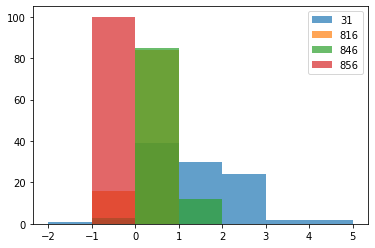

In [16]:
pm, mid = train_model(500,dropout = 0.1)
t[mid],s[mid], e[mid] = eval_model(pm)
p[mid] = pm
run_test(t[mid], s[mid], [31,816,846,856])

idx: 31 t: 18 p: 24
idx: 816 t: 20 p: 11
idx: 846 t: 21 p: 17
idx: 856 t: 11 p: 8


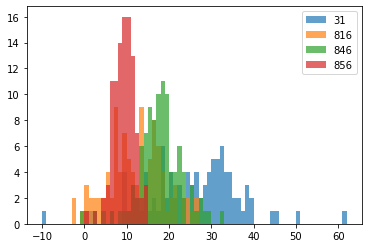

In [28]:
run_test(t[mid], s[mid], [31,816,846,856])

In [27]:
mid = 'mlp-e500-l10-10-5-student-d0.1'
save_full_pitmodel(mid, 'all')

Running evaluation: 100%|██████████| 4920/4920 [00:25<00:00, 190.28it/s]


{
    "MSE": 1.0011795475914422,
    "abs_error": 3900.250220794186,
    "abs_target_sum": 5031.092032168558,
    "abs_target_mean": 1.0225796813350727,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.1208939382641554,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 1635.6590444468143,
    "Coverage[0.1]": 0.13719512195121952,
    "QuantileLoss[0.5]": 3900.250220794186,
    "Coverage[0.5]": 0.28597560975609754,
    "QuantileLoss[0.9]": 1802.6259981363219,
    "Coverage[0.9]": 0.6449186991869919,
    "RMSE": 1.0005895999816519,
    "NRMSE": 0.9784954837703105,
    "ND": 0.7752293529627714,
    "wQuantileLoss[0.1]": 0.3251101418913607,
    "wQuantileLoss[0.5]": 0.7752293529627714,
    "wQuantileLoss[0.9]": 0.35829716224835856,
    "mean_wQuantileLoss": 0.48621221903416356,
    "MAE_Coverage": 0.1687669376693767
}
save model pitmodel-m60-mlp-e500-l10-10-5-student-d0.1.pickle with 1830 keys.


INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 143.39it/s, avg_epoch_loss=1.36]
INFO:root:Epoch[0] Elapsed time 0.699 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=1.360735
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 150.94it/s, avg_epoch_loss=0.703]
INFO:root:Epoch[1] Elapsed time 0.664 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.702564
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 134.99it/s, avg_epoch_loss=0.339]
INFO:root:Epoch[2] Elapsed time 0.742 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.339161
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 147.62it/s, avg_epoch_loss=0.253]
INFO:root:Epoch[3] Elapsed time 0.679 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=0.253489
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 143.48it/

100%|██████████| 100/100 [00:00<00:00, 144.76it/s, avg_epoch_loss=0.095]
INFO:root:Epoch[36] Elapsed time 0.693 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=0.095023
INFO:root:Epoch[37] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 144.69it/s, avg_epoch_loss=0.0606]
INFO:root:Epoch[37] Elapsed time 0.693 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=0.060584
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 145.11it/s, avg_epoch_loss=0.0614]
INFO:root:Epoch[38] Elapsed time 0.691 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=0.061361
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 142.09it/s, avg_epoch_loss=0.0635]
INFO:root:Epoch[39] Elapsed time 0.705 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=0.063486
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 150.28it/s, avg_epoch_loss=0.0603]
INFO:root:Epoch[40] Elapsed

100%|██████████| 100/100 [00:00<00:00, 150.48it/s, avg_epoch_loss=0.0488]
INFO:root:Epoch[72] Elapsed time 0.666 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=0.048754
INFO:root:Epoch[73] Learning rate is 0.000125
100%|██████████| 100/100 [00:00<00:00, 133.36it/s, avg_epoch_loss=0.0225]
INFO:root:Epoch[73] Elapsed time 0.752 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=0.022474
INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 100/100 [00:00<00:00, 149.37it/s, avg_epoch_loss=0.0669]
INFO:root:Epoch[74] Elapsed time 0.671 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=0.066886
INFO:root:Loading parameters from best epoch (44)
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 145.77it/s, avg_epoch_loss=0.0675]
INFO:root:Epoch[75] Elapsed time 0.688 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=0.067477
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 141

100%|██████████| 100/100 [00:00<00:00, 142.74it/s, avg_epoch_loss=0.0467]
INFO:root:Epoch[108] Elapsed time 0.702 seconds
INFO:root:Epoch[108] Evaluation metric 'epoch_loss'=0.046654
INFO:root:Epoch[109] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 146.84it/s, avg_epoch_loss=0.0546]
INFO:root:Epoch[109] Elapsed time 0.683 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=0.054632
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 145.87it/s, avg_epoch_loss=0.0603]
INFO:root:Epoch[110] Elapsed time 0.687 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=0.060331
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 150.39it/s, avg_epoch_loss=0.0397]
INFO:root:Epoch[111] Elapsed time 0.667 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=0.039697
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 150.20it/s, avg_epoch_loss=0.0735]
INFO:root:Epoch[11

100%|██████████| 100/100 [00:00<00:00, 155.53it/s, avg_epoch_loss=0.0633]
INFO:root:Epoch[144] Elapsed time 0.645 seconds
INFO:root:Epoch[144] Evaluation metric 'epoch_loss'=0.063261
INFO:root:Epoch[145] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 155.91it/s, avg_epoch_loss=0.0483]
INFO:root:Epoch[145] Elapsed time 0.643 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=0.048263
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 158.18it/s, avg_epoch_loss=0.0448]
INFO:root:Epoch[146] Elapsed time 0.634 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=0.044809
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.50it/s, avg_epoch_loss=0.0573]
INFO:root:Epoch[147] Elapsed time 0.613 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=0.057292
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.31it/s, avg_epoch_loss=0.0554]
INFO:root:Epoch[14

100%|██████████| 100/100 [00:00<00:00, 160.76it/s, avg_epoch_loss=0.0488]
INFO:root:Epoch[180] Elapsed time 0.623 seconds
INFO:root:Epoch[180] Evaluation metric 'epoch_loss'=0.048765
INFO:root:Epoch[181] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 159.92it/s, avg_epoch_loss=0.0314]
INFO:root:Epoch[181] Elapsed time 0.627 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=0.031386
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 155.90it/s, avg_epoch_loss=0.0331]
INFO:root:Epoch[182] Elapsed time 0.643 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=0.033111
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 156.94it/s, avg_epoch_loss=0.0669]
INFO:root:Epoch[183] Elapsed time 0.639 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=0.066855
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 156.30it/s, avg_epoch_loss=-.00219]
INFO:root:Epoch[1

100%|██████████| 100/100 [00:00<00:00, 156.61it/s, avg_epoch_loss=0.0154]
INFO:root:Epoch[216] Elapsed time 0.640 seconds
INFO:root:Epoch[216] Evaluation metric 'epoch_loss'=0.015446
INFO:root:Epoch[217] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 154.89it/s, avg_epoch_loss=0.0551]
INFO:root:Epoch[217] Elapsed time 0.647 seconds
INFO:root:Epoch[217] Evaluation metric 'epoch_loss'=0.055080
INFO:root:Epoch[218] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 156.75it/s, avg_epoch_loss=0.0507]
INFO:root:Epoch[218] Elapsed time 0.639 seconds
INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=0.050673
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.94it/s, avg_epoch_loss=-.0131]
INFO:root:Epoch[219] Elapsed time 0.619 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=-0.013106
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.76it/s, avg_epoch_loss=0.0525]
INFO:root:Epoch[2

100%|██████████| 100/100 [00:00<00:00, 137.96it/s, avg_epoch_loss=0.0174]
INFO:root:Epoch[252] Elapsed time 0.726 seconds
INFO:root:Epoch[252] Evaluation metric 'epoch_loss'=0.017417
INFO:root:Epoch[253] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 152.88it/s, avg_epoch_loss=0.0233]
INFO:root:Epoch[253] Elapsed time 0.656 seconds
INFO:root:Epoch[253] Evaluation metric 'epoch_loss'=0.023265
INFO:root:Epoch[254] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 155.78it/s, avg_epoch_loss=0.0181]
INFO:root:Epoch[254] Elapsed time 0.644 seconds
INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=0.018103
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 156.82it/s, avg_epoch_loss=0.0403]
INFO:root:Epoch[255] Elapsed time 0.639 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=0.040320
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.88it/s, avg_epoch_loss=0.027]
INFO:root:Epoch[256

100%|██████████| 100/100 [00:00<00:00, 137.70it/s, avg_epoch_loss=0.0257]
INFO:root:Epoch[288] Elapsed time 0.729 seconds
INFO:root:Epoch[288] Evaluation metric 'epoch_loss'=0.025741
INFO:root:Epoch[289] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 148.35it/s, avg_epoch_loss=0.016]
INFO:root:Epoch[289] Elapsed time 0.676 seconds
INFO:root:Epoch[289] Evaluation metric 'epoch_loss'=0.016037
INFO:root:Epoch[290] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 150.70it/s, avg_epoch_loss=0.0458]
INFO:root:Epoch[290] Elapsed time 0.666 seconds
INFO:root:Epoch[290] Evaluation metric 'epoch_loss'=0.045778
INFO:root:Epoch[291] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 141.00it/s, avg_epoch_loss=0.0194]
INFO:root:Epoch[291] Elapsed time 0.712 seconds
INFO:root:Epoch[291] Evaluation metric 'epoch_loss'=0.019447
INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 153.46it/s, avg_epoch_loss=0.0423]
INFO:root:Epoch[292

100%|██████████| 100/100 [00:00<00:00, 152.97it/s, avg_epoch_loss=0.0093]
INFO:root:Epoch[324] Elapsed time 0.656 seconds
INFO:root:Epoch[324] Evaluation metric 'epoch_loss'=0.009296
INFO:root:Epoch[325] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 154.53it/s, avg_epoch_loss=0.0157]
INFO:root:Epoch[325] Elapsed time 0.649 seconds
INFO:root:Epoch[325] Evaluation metric 'epoch_loss'=0.015656
INFO:root:Epoch[326] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 159.96it/s, avg_epoch_loss=0.0414]
INFO:root:Epoch[326] Elapsed time 0.627 seconds
INFO:root:Epoch[326] Evaluation metric 'epoch_loss'=0.041366
INFO:root:Epoch[327] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 159.98it/s, avg_epoch_loss=0.0321]
INFO:root:Epoch[327] Elapsed time 0.627 seconds
INFO:root:Epoch[327] Evaluation metric 'epoch_loss'=0.032053
INFO:root:Epoch[328] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 154.78it/s, avg_epoch_loss=-.0124]
INFO:root:Epoch[32

100%|██████████| 100/100 [00:00<00:00, 153.12it/s, avg_epoch_loss=0.018]
INFO:root:Epoch[360] Elapsed time 0.655 seconds
INFO:root:Epoch[360] Evaluation metric 'epoch_loss'=0.017989
INFO:root:Epoch[361] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 135.39it/s, avg_epoch_loss=0.0206]
INFO:root:Epoch[361] Elapsed time 0.741 seconds
INFO:root:Epoch[361] Evaluation metric 'epoch_loss'=0.020640
INFO:root:Epoch[362] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 141.10it/s, avg_epoch_loss=0.0493]
INFO:root:Epoch[362] Elapsed time 0.711 seconds
INFO:root:Epoch[362] Evaluation metric 'epoch_loss'=0.049289
INFO:root:Epoch[363] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 147.20it/s, avg_epoch_loss=-.00797]
INFO:root:Epoch[363] Elapsed time 0.681 seconds
INFO:root:Epoch[363] Evaluation metric 'epoch_loss'=-0.007969
INFO:root:Epoch[364] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 152.47it/s, avg_epoch_loss=0.0617]
INFO:root:Epoch[3

100%|██████████| 100/100 [00:00<00:00, 151.26it/s, avg_epoch_loss=0.0152]
INFO:root:Epoch[396] Elapsed time 0.663 seconds
INFO:root:Epoch[396] Evaluation metric 'epoch_loss'=0.015194
INFO:root:Epoch[397] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 145.57it/s, avg_epoch_loss=0.0253]
INFO:root:Epoch[397] Elapsed time 0.689 seconds
INFO:root:Epoch[397] Evaluation metric 'epoch_loss'=0.025272
INFO:root:Epoch[398] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 150.22it/s, avg_epoch_loss=-.0127]
INFO:root:Epoch[398] Elapsed time 0.668 seconds
INFO:root:Epoch[398] Evaluation metric 'epoch_loss'=-0.012735
INFO:root:Epoch[399] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 153.08it/s, avg_epoch_loss=0.012]
INFO:root:Epoch[399] Elapsed time 0.655 seconds
INFO:root:Epoch[399] Evaluation metric 'epoch_loss'=0.012009
INFO:root:Epoch[400] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.21it/s, avg_epoch_loss=0.035]
INFO:root:Epoch[400

100%|██████████| 100/100 [00:00<00:00, 161.09it/s, avg_epoch_loss=0.0298]
INFO:root:Epoch[432] Elapsed time 0.623 seconds
INFO:root:Epoch[432] Evaluation metric 'epoch_loss'=0.029842
INFO:root:Epoch[433] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 149.65it/s, avg_epoch_loss=-.00302]
INFO:root:Epoch[433] Elapsed time 0.671 seconds
INFO:root:Epoch[433] Evaluation metric 'epoch_loss'=-0.003024
INFO:root:Epoch[434] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 154.74it/s, avg_epoch_loss=0.00876]
INFO:root:Epoch[434] Elapsed time 0.648 seconds
INFO:root:Epoch[434] Evaluation metric 'epoch_loss'=0.008758
INFO:root:Epoch[435] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 157.81it/s, avg_epoch_loss=0.0218]
INFO:root:Epoch[435] Elapsed time 0.635 seconds
INFO:root:Epoch[435] Evaluation metric 'epoch_loss'=0.021814
INFO:root:Epoch[436] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 155.98it/s, avg_epoch_loss=0.0138]
INFO:root:Epoch

100%|██████████| 100/100 [00:00<00:00, 158.95it/s, avg_epoch_loss=0.00203]
INFO:root:Epoch[468] Elapsed time 0.631 seconds
INFO:root:Epoch[468] Evaluation metric 'epoch_loss'=0.002029
INFO:root:Epoch[469] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 158.56it/s, avg_epoch_loss=0.00473]
INFO:root:Epoch[469] Elapsed time 0.634 seconds
INFO:root:Epoch[469] Evaluation metric 'epoch_loss'=0.004730
INFO:root:Epoch[470] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 152.39it/s, avg_epoch_loss=0.0121]
INFO:root:Epoch[470] Elapsed time 0.658 seconds
INFO:root:Epoch[470] Evaluation metric 'epoch_loss'=0.012083
INFO:root:Epoch[471] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 156.18it/s, avg_epoch_loss=0.0352]
INFO:root:Epoch[471] Elapsed time 0.642 seconds
INFO:root:Epoch[471] Evaluation metric 'epoch_loss'=0.035163
INFO:root:Epoch[472] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 159.48it/s, avg_epoch_loss=-.00243]
INFO:root:Epoch

{
    "MSE": 0.3859889100206778,
    "abs_error": 1689.8474570534445,
    "abs_target_sum": 3779.0495181689503,
    "abs_target_mean": 1.03877117046975,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.7098326737678045,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 609.8341871226564,
    "Coverage[0.1]": 0.08081363386476086,
    "QuantileLoss[0.5]": 1689.8474570534445,
    "Coverage[0.5]": 0.20588235294117646,
    "QuantileLoss[0.9]": 1540.294984068622,
    "Coverage[0.9]": 0.45794392523364486,
    "RMSE": 0.6212800576396106,
    "NRMSE": 0.5980913557301144,
    "ND": 0.44716203080403677,
    "wQuantileLoss[0.1]": 0.1613723726536765,
    "wQuantileLoss[0.5]": 0.44716203080403677,
    "wQuantileLoss[0.9]": 0.40758793359631224,
    "mean_wQuantileLoss": 0.3387074456846752,
    "MAE_Coverage": 0.251786695986806
}
idx: 31 t: 31 p: 0
idx: 816 t: 44 p: 1
idx: 846 t: 14 p: 0
idx: 856 t: 4 p: -1


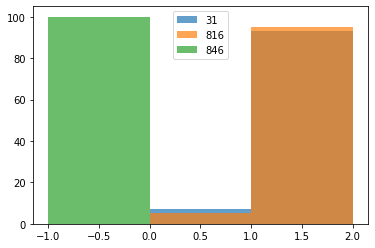

In [18]:
runid = 'sel'
trainset, testset, train_ds, test_ds, scaler = _data[runid]
pm, mid = train_model(500,dropout = 0.1, id = runid)
t[mid],s[mid], e[mid] = eval_model(pm)
p[mid] = pm
run_test(t[mid], s[mid], [31,816,846,856])

idx: 31 t: 31 p: 28
idx: 816 t: 44 p: 28
idx: 846 t: 14 p: 9
idx: 856 t: 4 p: 1


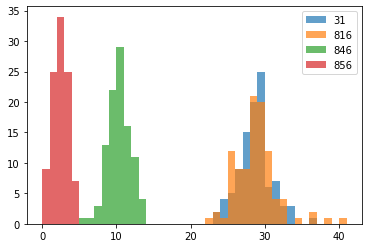

In [20]:
run_test(t[mid], s[mid], [31,816,846,856])

In [32]:
len(test_all)

4920

In [40]:
mid =  'mlp-dsel-e500-l10-10-5-student-d0.1'
save_full_pitmodel(mid, 'sel', maxgap=65)

make full testdb: 2145 records


Running evaluation: 100%|██████████| 2145/2145 [00:11<00:00, 192.67it/s]


{
    "MSE": 1.46577283026016,
    "abs_error": 2168.5348833191742,
    "abs_target_sum": 3779.5638833230714,
    "abs_target_mean": 1.7620344444396603,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.7642490638870966,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 2450.6958254705332,
    "Coverage[0.1]": 0.6377622377622377,
    "QuantileLoss[0.5]": 2168.5348833191742,
    "Coverage[0.5]": 0.6662004662004662,
    "QuantileLoss[0.9]": 1309.0750581305524,
    "Coverage[0.9]": 0.6881118881118881,
    "RMSE": 1.2106910548361047,
    "NRMSE": 0.6870984041524303,
    "ND": 0.5737526736583569,
    "wQuantileLoss[0.1]": 0.6484070387813713,
    "wQuantileLoss[0.5]": 0.5737526736583569,
    "wQuantileLoss[0.9]": 0.3463561137057925,
    "mean_wQuantileLoss": 0.5228386087151735,
    "MAE_Coverage": 0.3052836052836053
}
save model pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1.pickle with 2145 keys.


In [23]:
s.keys()

dict_keys(['mlp-e500-l10-10-5-student-d0.1', 'mlp-dsel-e500-l10-10-5-student-d0.1'])

In [14]:
pm, mid = train_model(500,dropout = 0.1)
t[mid],s[mid], e[mid] = eval_model(pm)
p[mid] = pm
run_test(t[mid], s[mid], [31,816,846,856])

INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 150.99it/s, avg_epoch_loss=1.39]
INFO:root:Epoch[0] Elapsed time 0.666 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=1.394312
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 160.10it/s, avg_epoch_loss=0.687]
INFO:root:Epoch[1] Elapsed time 0.626 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.686772
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 131.25it/s, avg_epoch_loss=0.472]
INFO:root:Epoch[2] Elapsed time 0.764 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.471568
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 160.94it/s, avg_epoch_loss=0.449]
INFO:root:Epoch[3] Elapsed time 0.624 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=0.448830
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 164.28it/

INFO:root:Epoch[73] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 155.06it/s, avg_epoch_loss=0.102]
INFO:root:Epoch[73] Elapsed time 0.646 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=0.102307
INFO:root:Epoch[74] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 151.69it/s, avg_epoch_loss=0.126]
INFO:root:Epoch[74] Elapsed time 0.661 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=0.125568
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 152.60it/s, avg_epoch_loss=0.0981]
INFO:root:Epoch[75] Elapsed time 0.657 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=0.098130
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 151.54it/s, avg_epoch_loss=0.11]
INFO:root:Epoch[76] Elapsed time 0.662 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=0.109842
INFO:root:Loading parameters from best epoch (66)
INFO:root:Epoch[77] Learning rate is 0.0005
100%|█████████

100%|██████████| 100/100 [00:00<00:00, 160.17it/s, avg_epoch_loss=0.112]
INFO:root:Epoch[144] Elapsed time 0.626 seconds
INFO:root:Epoch[144] Evaluation metric 'epoch_loss'=0.112488
INFO:root:Epoch[145] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 158.75it/s, avg_epoch_loss=0.112]
INFO:root:Epoch[145] Elapsed time 0.632 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=0.112278
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 159.89it/s, avg_epoch_loss=0.108]
INFO:root:Epoch[146] Elapsed time 0.627 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=0.108080
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.34it/s, avg_epoch_loss=0.0745]
INFO:root:Epoch[147] Elapsed time 0.622 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=0.074546
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.96it/s, avg_epoch_loss=0.118]
INFO:root:Epoch[148] E

100%|██████████| 100/100 [00:00<00:00, 147.69it/s, avg_epoch_loss=0.091]
INFO:root:Epoch[216] Elapsed time 0.679 seconds
INFO:root:Epoch[216] Evaluation metric 'epoch_loss'=0.091002
INFO:root:Epoch[217] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.91it/s, avg_epoch_loss=0.116]
INFO:root:Epoch[217] Elapsed time 0.612 seconds
INFO:root:Epoch[217] Evaluation metric 'epoch_loss'=0.116435
INFO:root:Epoch[218] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.07it/s, avg_epoch_loss=0.104]
INFO:root:Epoch[218] Elapsed time 0.619 seconds
INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=0.103997
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.27it/s, avg_epoch_loss=0.105]
INFO:root:Epoch[219] Elapsed time 0.618 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=0.104970
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.43it/s, avg_epoch_loss=0.0919]
INFO:root:Epoch[220] E

100%|██████████| 100/100 [00:00<00:00, 151.95it/s, avg_epoch_loss=0.0917]
INFO:root:Epoch[288] Elapsed time 0.660 seconds
INFO:root:Epoch[288] Evaluation metric 'epoch_loss'=0.091706
INFO:root:Epoch[289] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 154.32it/s, avg_epoch_loss=0.0861]
INFO:root:Epoch[289] Elapsed time 0.650 seconds
INFO:root:Epoch[289] Evaluation metric 'epoch_loss'=0.086134
INFO:root:Epoch[290] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 142.61it/s, avg_epoch_loss=0.114]
INFO:root:Epoch[290] Elapsed time 0.703 seconds
INFO:root:Epoch[290] Evaluation metric 'epoch_loss'=0.113970
INFO:root:Epoch[291] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 147.94it/s, avg_epoch_loss=0.0903]
INFO:root:Epoch[291] Elapsed time 0.678 seconds
INFO:root:Epoch[291] Evaluation metric 'epoch_loss'=0.090340
INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 156.42it/s, avg_epoch_loss=0.0834]
INFO:root:Epoch[292

100%|██████████| 100/100 [00:00<00:00, 148.79it/s, avg_epoch_loss=0.107]
INFO:root:Epoch[360] Elapsed time 0.674 seconds
INFO:root:Epoch[360] Evaluation metric 'epoch_loss'=0.107215
INFO:root:Epoch[361] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 125.38it/s, avg_epoch_loss=0.0987]
INFO:root:Epoch[361] Elapsed time 0.800 seconds
INFO:root:Epoch[361] Evaluation metric 'epoch_loss'=0.098733
INFO:root:Epoch[362] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 148.82it/s, avg_epoch_loss=0.0769]
INFO:root:Epoch[362] Elapsed time 0.674 seconds
INFO:root:Epoch[362] Evaluation metric 'epoch_loss'=0.076943
INFO:root:Epoch[363] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 147.97it/s, avg_epoch_loss=0.0963]
INFO:root:Epoch[363] Elapsed time 0.678 seconds
INFO:root:Epoch[363] Evaluation metric 'epoch_loss'=0.096282
INFO:root:Epoch[364] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 148.25it/s, avg_epoch_loss=0.0723]
INFO:root:Epoch[364

100%|██████████| 100/100 [00:00<00:00, 164.58it/s, avg_epoch_loss=0.0661]
INFO:root:Epoch[432] Elapsed time 0.609 seconds
INFO:root:Epoch[432] Evaluation metric 'epoch_loss'=0.066137
INFO:root:Epoch[433] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 174.98it/s, avg_epoch_loss=0.0966]
INFO:root:Epoch[433] Elapsed time 0.573 seconds
INFO:root:Epoch[433] Evaluation metric 'epoch_loss'=0.096619
INFO:root:Epoch[434] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.18it/s, avg_epoch_loss=0.104]
INFO:root:Epoch[434] Elapsed time 0.579 seconds
INFO:root:Epoch[434] Evaluation metric 'epoch_loss'=0.103724
INFO:root:Epoch[435] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 167.54it/s, avg_epoch_loss=0.0853]
INFO:root:Epoch[435] Elapsed time 0.599 seconds
INFO:root:Epoch[435] Evaluation metric 'epoch_loss'=0.085283
INFO:root:Epoch[436] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 172.50it/s, avg_epoch_loss=0.0957]
INFO:root:Epoch[436

{
    "MSE": 0.15168725313945589,
    "abs_error": 1102.9535928098603,
    "abs_target_sum": 3083.21469670675,
    "abs_target_mean": 0.8475026653949286,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.5607063337889383,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 523.7104673581646,
    "Coverage[0.1]": 0.23721825178669598,
    "QuantileLoss[0.5]": 1102.9535928098603,
    "Coverage[0.5]": 0.6327652556349642,
    "QuantileLoss[0.9]": 570.7529622530515,
    "Coverage[0.9]": 0.848543155579989,
    "RMSE": 0.38947047787920447,
    "NRMSE": 0.45955074099703835,
    "ND": 0.35772844297477874,
    "wQuantileLoss[0.1]": 0.16985857907253468,
    "wQuantileLoss[0.5]": 0.35772844297477874,
    "wQuantileLoss[0.9]": 0.18511619150709333,
    "mean_wQuantileLoss": 0.23756773785146892,
    "MAE_Coverage": 0.10714678394722373
}


NameError: name 'run_test' is not defined

idx: 31 t: 31 p: 35
idx: 816 t: 44 p: 34
idx: 846 t: 14 p: 11
idx: 856 t: 4 p: 4


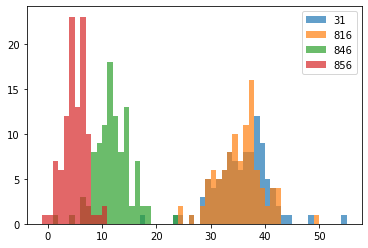

In [16]:
run_test(t[mid], s[mid], [31,816,846,856])

INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 143.36it/s, avg_epoch_loss=1.16]
INFO:root:Epoch[0] Elapsed time 0.700 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=1.156967
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 148.18it/s, avg_epoch_loss=0.624]
INFO:root:Epoch[1] Elapsed time 0.677 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.624029
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 151.04it/s, avg_epoch_loss=0.491]
INFO:root:Epoch[2] Elapsed time 0.664 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.491062
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 149.27it/s, avg_epoch_loss=0.448]
INFO:root:Epoch[3] Elapsed time 0.672 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=0.448230
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 152.47it/

INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=0.127263
INFO:root:Epoch[73] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 150.46it/s, avg_epoch_loss=0.116]
INFO:root:Epoch[73] Elapsed time 0.667 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=0.115895
INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 154.02it/s, avg_epoch_loss=0.131]
INFO:root:Epoch[74] Elapsed time 0.651 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=0.131315
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 148.19it/s, avg_epoch_loss=0.113]
INFO:root:Epoch[75] Elapsed time 0.677 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=0.113201
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 147.39it/s, avg_epoch_loss=0.139]
INFO:root:Epoch[76] Elapsed time 0.680 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=0.138689
INFO:root:Epoch[77] Learning rate is 0.0005


100%|██████████| 100/100 [00:00<00:00, 141.36it/s, avg_epoch_loss=0.128]
INFO:root:Epoch[144] Elapsed time 0.709 seconds
INFO:root:Epoch[144] Evaluation metric 'epoch_loss'=0.128182
INFO:root:Epoch[145] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 141.65it/s, avg_epoch_loss=0.138]
INFO:root:Epoch[145] Elapsed time 0.708 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=0.138174
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 142.35it/s, avg_epoch_loss=0.126]
INFO:root:Epoch[146] Elapsed time 0.704 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=0.125644
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 147.51it/s, avg_epoch_loss=0.143]
INFO:root:Epoch[147] Elapsed time 0.680 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=0.143155
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 148.35it/s, avg_epoch_loss=0.131]
INFO:root:Epoch[148] El

100%|██████████| 100/100 [00:00<00:00, 151.82it/s, avg_epoch_loss=0.106]
INFO:root:Epoch[216] Elapsed time 0.661 seconds
INFO:root:Epoch[216] Evaluation metric 'epoch_loss'=0.105796
INFO:root:Epoch[217] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 149.10it/s, avg_epoch_loss=0.146]
INFO:root:Epoch[217] Elapsed time 0.673 seconds
INFO:root:Epoch[217] Evaluation metric 'epoch_loss'=0.145905
INFO:root:Epoch[218] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 157.08it/s, avg_epoch_loss=0.108]
INFO:root:Epoch[218] Elapsed time 0.639 seconds
INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=0.108459
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 147.32it/s, avg_epoch_loss=0.103]
INFO:root:Epoch[219] Elapsed time 0.681 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=0.102806
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 152.88it/s, avg_epoch_loss=0.133]
INFO:root:Epoch[220] El

100%|██████████| 100/100 [00:00<00:00, 160.70it/s, avg_epoch_loss=0.106]
INFO:root:Epoch[288] Elapsed time 0.624 seconds
INFO:root:Epoch[288] Evaluation metric 'epoch_loss'=0.105914
INFO:root:Epoch[289] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 160.59it/s, avg_epoch_loss=0.11]
INFO:root:Epoch[289] Elapsed time 0.625 seconds
INFO:root:Epoch[289] Evaluation metric 'epoch_loss'=0.109743
INFO:root:Epoch[290] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 158.22it/s, avg_epoch_loss=0.141]
INFO:root:Epoch[290] Elapsed time 0.634 seconds
INFO:root:Epoch[290] Evaluation metric 'epoch_loss'=0.140606
INFO:root:Epoch[291] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 159.23it/s, avg_epoch_loss=0.107]
INFO:root:Epoch[291] Elapsed time 0.630 seconds
INFO:root:Epoch[291] Evaluation metric 'epoch_loss'=0.106788
INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 157.57it/s, avg_epoch_loss=0.114]
INFO:root:Epoch[292] Ela

100%|██████████| 100/100 [00:00<00:00, 154.35it/s, avg_epoch_loss=0.126]
INFO:root:Epoch[360] Elapsed time 0.650 seconds
INFO:root:Epoch[360] Evaluation metric 'epoch_loss'=0.126465
INFO:root:Epoch[361] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 155.53it/s, avg_epoch_loss=0.126]
INFO:root:Epoch[361] Elapsed time 0.645 seconds
INFO:root:Epoch[361] Evaluation metric 'epoch_loss'=0.126101
INFO:root:Epoch[362] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 158.92it/s, avg_epoch_loss=0.119]
INFO:root:Epoch[362] Elapsed time 0.631 seconds
INFO:root:Epoch[362] Evaluation metric 'epoch_loss'=0.118873
INFO:root:Epoch[363] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 159.28it/s, avg_epoch_loss=0.134]
INFO:root:Epoch[363] Elapsed time 0.630 seconds
INFO:root:Epoch[363] Evaluation metric 'epoch_loss'=0.134257
INFO:root:Epoch[364] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 160.40it/s, avg_epoch_loss=0.106]
INFO:root:Epoch[364] El

100%|██████████| 100/100 [00:00<00:00, 163.52it/s, avg_epoch_loss=0.088]
INFO:root:Epoch[432] Elapsed time 0.614 seconds
INFO:root:Epoch[432] Evaluation metric 'epoch_loss'=0.088008
INFO:root:Epoch[433] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.68it/s, avg_epoch_loss=0.133]
INFO:root:Epoch[433] Elapsed time 0.602 seconds
INFO:root:Epoch[433] Evaluation metric 'epoch_loss'=0.132503
INFO:root:Epoch[434] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.31it/s, avg_epoch_loss=0.101]
INFO:root:Epoch[434] Elapsed time 0.619 seconds
INFO:root:Epoch[434] Evaluation metric 'epoch_loss'=0.100890
INFO:root:Epoch[435] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.14it/s, avg_epoch_loss=0.12]
INFO:root:Epoch[435] Elapsed time 0.619 seconds
INFO:root:Epoch[435] Evaluation metric 'epoch_loss'=0.120288
INFO:root:Epoch[436] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.95it/s, avg_epoch_loss=0.123]
INFO:root:Epoch[436] Ela

100%|██████████| 100/100 [00:00<00:00, 150.48it/s, avg_epoch_loss=0.122]
INFO:root:Epoch[504] Elapsed time 0.666 seconds
INFO:root:Epoch[504] Evaluation metric 'epoch_loss'=0.121923
INFO:root:Epoch[505] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 150.67it/s, avg_epoch_loss=0.102]
INFO:root:Epoch[505] Elapsed time 0.665 seconds
INFO:root:Epoch[505] Evaluation metric 'epoch_loss'=0.102100
INFO:root:Epoch[506] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 152.41it/s, avg_epoch_loss=0.138]
INFO:root:Epoch[506] Elapsed time 0.658 seconds
INFO:root:Epoch[506] Evaluation metric 'epoch_loss'=0.137861
INFO:root:Epoch[507] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 152.13it/s, avg_epoch_loss=0.0984]
INFO:root:Epoch[507] Elapsed time 0.659 seconds
INFO:root:Epoch[507] Evaluation metric 'epoch_loss'=0.098445
INFO:root:Epoch[508] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 152.93it/s, avg_epoch_loss=0.0979]
INFO:root:Epoch[508] 

100%|██████████| 100/100 [00:00<00:00, 150.51it/s, avg_epoch_loss=0.137]
INFO:root:Epoch[576] Elapsed time 0.666 seconds
INFO:root:Epoch[576] Evaluation metric 'epoch_loss'=0.137378
INFO:root:Epoch[577] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 153.09it/s, avg_epoch_loss=0.0962]
INFO:root:Epoch[577] Elapsed time 0.655 seconds
INFO:root:Epoch[577] Evaluation metric 'epoch_loss'=0.096167
INFO:root:Epoch[578] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 154.20it/s, avg_epoch_loss=0.076]
INFO:root:Epoch[578] Elapsed time 0.650 seconds
INFO:root:Epoch[578] Evaluation metric 'epoch_loss'=0.075969
INFO:root:Epoch[579] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 150.00it/s, avg_epoch_loss=0.132]
INFO:root:Epoch[579] Elapsed time 0.668 seconds
INFO:root:Epoch[579] Evaluation metric 'epoch_loss'=0.131848
INFO:root:Epoch[580] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 155.56it/s, avg_epoch_loss=0.114]
INFO:root:Epoch[580] E

100%|██████████| 100/100 [00:00<00:00, 130.68it/s, avg_epoch_loss=0.102]
INFO:root:Epoch[648] Elapsed time 0.768 seconds
INFO:root:Epoch[648] Evaluation metric 'epoch_loss'=0.102474
INFO:root:Epoch[649] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 139.77it/s, avg_epoch_loss=0.112]
INFO:root:Epoch[649] Elapsed time 0.718 seconds
INFO:root:Epoch[649] Evaluation metric 'epoch_loss'=0.112262
INFO:root:Epoch[650] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 142.62it/s, avg_epoch_loss=0.0902]
INFO:root:Epoch[650] Elapsed time 0.703 seconds
INFO:root:Epoch[650] Evaluation metric 'epoch_loss'=0.090250
INFO:root:Epoch[651] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 145.62it/s, avg_epoch_loss=0.125]
INFO:root:Epoch[651] Elapsed time 0.688 seconds
INFO:root:Epoch[651] Evaluation metric 'epoch_loss'=0.125132
INFO:root:Epoch[652] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 138.61it/s, avg_epoch_loss=0.123]
INFO:root:Epoch[652] E

100%|██████████| 100/100 [00:00<00:00, 152.05it/s, avg_epoch_loss=0.118]
INFO:root:Epoch[720] Elapsed time 0.660 seconds
INFO:root:Epoch[720] Evaluation metric 'epoch_loss'=0.117878
INFO:root:Epoch[721] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 147.61it/s, avg_epoch_loss=0.11]
INFO:root:Epoch[721] Elapsed time 0.679 seconds
INFO:root:Epoch[721] Evaluation metric 'epoch_loss'=0.109672
INFO:root:Epoch[722] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.64it/s, avg_epoch_loss=0.132]
INFO:root:Epoch[722] Elapsed time 0.617 seconds
INFO:root:Epoch[722] Evaluation metric 'epoch_loss'=0.131902
INFO:root:Epoch[723] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 154.83it/s, avg_epoch_loss=0.105]
INFO:root:Epoch[723] Elapsed time 0.648 seconds
INFO:root:Epoch[723] Evaluation metric 'epoch_loss'=0.104780
INFO:root:Epoch[724] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 152.30it/s, avg_epoch_loss=0.106]
INFO:root:Epoch[724] Ela

100%|██████████| 100/100 [00:00<00:00, 161.93it/s, avg_epoch_loss=0.115]
INFO:root:Epoch[792] Elapsed time 0.619 seconds
INFO:root:Epoch[792] Evaluation metric 'epoch_loss'=0.115308
INFO:root:Epoch[793] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.80it/s, avg_epoch_loss=0.127]
INFO:root:Epoch[793] Elapsed time 0.620 seconds
INFO:root:Epoch[793] Evaluation metric 'epoch_loss'=0.126689
INFO:root:Epoch[794] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.85it/s, avg_epoch_loss=0.121]
INFO:root:Epoch[794] Elapsed time 0.616 seconds
INFO:root:Epoch[794] Evaluation metric 'epoch_loss'=0.121124
INFO:root:Epoch[795] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.07it/s, avg_epoch_loss=0.153]
INFO:root:Epoch[795] Elapsed time 0.611 seconds
INFO:root:Epoch[795] Evaluation metric 'epoch_loss'=0.153291
INFO:root:Epoch[796] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.77it/s, avg_epoch_loss=0.11]
INFO:root:Epoch[796] Ela

100%|██████████| 100/100 [00:00<00:00, 162.75it/s, avg_epoch_loss=0.139]
INFO:root:Epoch[864] Elapsed time 0.616 seconds
INFO:root:Epoch[864] Evaluation metric 'epoch_loss'=0.138966
INFO:root:Epoch[865] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.27it/s, avg_epoch_loss=0.115]
INFO:root:Epoch[865] Elapsed time 0.603 seconds
INFO:root:Epoch[865] Evaluation metric 'epoch_loss'=0.115005
INFO:root:Epoch[866] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.56it/s, avg_epoch_loss=0.118]
INFO:root:Epoch[866] Elapsed time 0.606 seconds
INFO:root:Epoch[866] Evaluation metric 'epoch_loss'=0.118222
INFO:root:Epoch[867] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.23it/s, avg_epoch_loss=0.0996]
INFO:root:Epoch[867] Elapsed time 0.611 seconds
INFO:root:Epoch[867] Evaluation metric 'epoch_loss'=0.099555
INFO:root:Epoch[868] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.71it/s, avg_epoch_loss=0.135]
INFO:root:Epoch[868] E

100%|██████████| 100/100 [00:00<00:00, 159.30it/s, avg_epoch_loss=0.0973]
INFO:root:Epoch[936] Elapsed time 0.629 seconds
INFO:root:Epoch[936] Evaluation metric 'epoch_loss'=0.097330
INFO:root:Epoch[937] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.83it/s, avg_epoch_loss=0.0959]
INFO:root:Epoch[937] Elapsed time 0.612 seconds
INFO:root:Epoch[937] Evaluation metric 'epoch_loss'=0.095906
INFO:root:Epoch[938] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.29it/s, avg_epoch_loss=0.095]
INFO:root:Epoch[938] Elapsed time 0.622 seconds
INFO:root:Epoch[938] Evaluation metric 'epoch_loss'=0.095034
INFO:root:Epoch[939] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.24it/s, avg_epoch_loss=0.112]
INFO:root:Epoch[939] Elapsed time 0.614 seconds
INFO:root:Epoch[939] Evaluation metric 'epoch_loss'=0.112496
INFO:root:Epoch[940] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.63it/s, avg_epoch_loss=0.118]
INFO:root:Epoch[940] 

100%|██████████| 100/100 [00:00<00:00, 162.64it/s, avg_epoch_loss=0.117]
INFO:root:Epoch[1008] Elapsed time 0.617 seconds
INFO:root:Epoch[1008] Evaluation metric 'epoch_loss'=0.117078
INFO:root:Epoch[1009] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.67it/s, avg_epoch_loss=0.105]
INFO:root:Epoch[1009] Elapsed time 0.620 seconds
INFO:root:Epoch[1009] Evaluation metric 'epoch_loss'=0.104589
INFO:root:Epoch[1010] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.94it/s, avg_epoch_loss=0.105]
INFO:root:Epoch[1010] Elapsed time 0.612 seconds
INFO:root:Epoch[1010] Evaluation metric 'epoch_loss'=0.104984
INFO:root:Epoch[1011] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.58it/s, avg_epoch_loss=0.0984]
INFO:root:Epoch[1011] Elapsed time 0.605 seconds
INFO:root:Epoch[1011] Evaluation metric 'epoch_loss'=0.098441
INFO:root:Epoch[1012] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.81it/s, avg_epoch_loss=0.138]
INFO:root:

INFO:root:Epoch[1044] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.35it/s, avg_epoch_loss=0.0863]
INFO:root:Epoch[1044] Elapsed time 0.618 seconds
INFO:root:Epoch[1044] Evaluation metric 'epoch_loss'=0.086324
INFO:root:Epoch[1045] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.38it/s, avg_epoch_loss=0.129]
INFO:root:Epoch[1045] Elapsed time 0.617 seconds
INFO:root:Epoch[1045] Evaluation metric 'epoch_loss'=0.129228
INFO:root:Epoch[1046] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 160.96it/s, avg_epoch_loss=0.122]
INFO:root:Epoch[1046] Elapsed time 0.623 seconds
INFO:root:Epoch[1046] Evaluation metric 'epoch_loss'=0.122241
INFO:root:Epoch[1047] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.91it/s, avg_epoch_loss=0.0879]
INFO:root:Epoch[1047] Elapsed time 0.615 seconds
INFO:root:Epoch[1047] Evaluation metric 'epoch_loss'=0.087886
INFO:root:Epoch[1048] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00

INFO:root:Epoch[1079] Evaluation metric 'epoch_loss'=0.115347
INFO:root:Epoch[1080] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.82it/s, avg_epoch_loss=0.109]
INFO:root:Epoch[1080] Elapsed time 0.605 seconds
INFO:root:Epoch[1080] Evaluation metric 'epoch_loss'=0.108690
INFO:root:Epoch[1081] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.78it/s, avg_epoch_loss=0.108]
INFO:root:Epoch[1081] Elapsed time 0.612 seconds
INFO:root:Epoch[1081] Evaluation metric 'epoch_loss'=0.107801
INFO:root:Epoch[1082] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.48it/s, avg_epoch_loss=0.121]
INFO:root:Epoch[1082] Elapsed time 0.621 seconds
INFO:root:Epoch[1082] Evaluation metric 'epoch_loss'=0.120832
INFO:root:Epoch[1083] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.01it/s, avg_epoch_loss=0.0918]
INFO:root:Epoch[1083] Elapsed time 0.604 seconds
INFO:root:Epoch[1083] Evaluation metric 'epoch_loss'=0.091800
INFO:root:Epoch[1084]

INFO:root:Epoch[1151] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.07it/s, avg_epoch_loss=0.112]
INFO:root:Epoch[1151] Elapsed time 0.608 seconds
INFO:root:Epoch[1151] Evaluation metric 'epoch_loss'=0.111700
INFO:root:Epoch[1152] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.73it/s, avg_epoch_loss=0.138]
INFO:root:Epoch[1152] Elapsed time 0.612 seconds
INFO:root:Epoch[1152] Evaluation metric 'epoch_loss'=0.138070
INFO:root:Epoch[1153] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.09it/s, avg_epoch_loss=0.0974]
INFO:root:Epoch[1153] Elapsed time 0.608 seconds
INFO:root:Epoch[1153] Evaluation metric 'epoch_loss'=0.097437
INFO:root:Epoch[1154] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 159.97it/s, avg_epoch_loss=0.124]
INFO:root:Epoch[1154] Elapsed time 0.627 seconds
INFO:root:Epoch[1154] Evaluation metric 'epoch_loss'=0.124006
INFO:root:Epoch[1155] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00,

INFO:root:Epoch[1187] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 147.73it/s, avg_epoch_loss=0.0941]
INFO:root:Epoch[1187] Elapsed time 0.678 seconds
INFO:root:Epoch[1187] Evaluation metric 'epoch_loss'=0.094052
INFO:root:Epoch[1188] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.65it/s, avg_epoch_loss=0.133]
INFO:root:Epoch[1188] Elapsed time 0.620 seconds
INFO:root:Epoch[1188] Evaluation metric 'epoch_loss'=0.132867
INFO:root:Epoch[1189] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.45it/s, avg_epoch_loss=0.0994]
INFO:root:Epoch[1189] Elapsed time 0.606 seconds
INFO:root:Epoch[1189] Evaluation metric 'epoch_loss'=0.099369
INFO:root:Epoch[1190] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.63it/s, avg_epoch_loss=0.0872]
INFO:root:Epoch[1190] Elapsed time 0.609 seconds
INFO:root:Epoch[1190] Evaluation metric 'epoch_loss'=0.087156
INFO:root:Epoch[1191] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:0

INFO:root:Epoch[1223] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 168.83it/s, avg_epoch_loss=0.0704]
INFO:root:Epoch[1223] Elapsed time 0.594 seconds
INFO:root:Epoch[1223] Evaluation metric 'epoch_loss'=0.070359
INFO:root:Epoch[1224] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 168.89it/s, avg_epoch_loss=0.0775]
INFO:root:Epoch[1224] Elapsed time 0.594 seconds
INFO:root:Epoch[1224] Evaluation metric 'epoch_loss'=0.077485
INFO:root:Epoch[1225] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.15it/s, avg_epoch_loss=0.116]
INFO:root:Epoch[1225] Elapsed time 0.611 seconds
INFO:root:Epoch[1225] Evaluation metric 'epoch_loss'=0.115701
INFO:root:Epoch[1226] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.77it/s, avg_epoch_loss=0.11]
INFO:root:Epoch[1226] Elapsed time 0.609 seconds
INFO:root:Epoch[1226] Evaluation metric 'epoch_loss'=0.109887
INFO:root:Epoch[1227] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00,

INFO:root:Epoch[1259] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 169.35it/s, avg_epoch_loss=0.125]
INFO:root:Epoch[1259] Elapsed time 0.592 seconds
INFO:root:Epoch[1259] Evaluation metric 'epoch_loss'=0.124611
INFO:root:Epoch[1260] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.37it/s, avg_epoch_loss=0.105]
INFO:root:Epoch[1260] Elapsed time 0.603 seconds
INFO:root:Epoch[1260] Evaluation metric 'epoch_loss'=0.105329
INFO:root:Epoch[1261] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 168.65it/s, avg_epoch_loss=0.131]
INFO:root:Epoch[1261] Elapsed time 0.594 seconds
INFO:root:Epoch[1261] Evaluation metric 'epoch_loss'=0.131064
INFO:root:Epoch[1262] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 167.11it/s, avg_epoch_loss=0.0966]
INFO:root:Epoch[1262] Elapsed time 0.600 seconds
INFO:root:Epoch[1262] Evaluation metric 'epoch_loss'=0.096556
INFO:root:Epoch[1263] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00,

INFO:root:Epoch[1295] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 167.06it/s, avg_epoch_loss=0.121]
INFO:root:Epoch[1295] Elapsed time 0.600 seconds
INFO:root:Epoch[1295] Evaluation metric 'epoch_loss'=0.121427
INFO:root:Epoch[1296] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 167.78it/s, avg_epoch_loss=0.0912]
INFO:root:Epoch[1296] Elapsed time 0.598 seconds
INFO:root:Epoch[1296] Evaluation metric 'epoch_loss'=0.091182
INFO:root:Epoch[1297] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.57it/s, avg_epoch_loss=0.0882]
INFO:root:Epoch[1297] Elapsed time 0.602 seconds
INFO:root:Epoch[1297] Evaluation metric 'epoch_loss'=0.088221
INFO:root:Epoch[1298] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.59it/s, avg_epoch_loss=0.113]
INFO:root:Epoch[1298] Elapsed time 0.605 seconds
INFO:root:Epoch[1298] Evaluation metric 'epoch_loss'=0.112923
INFO:root:Epoch[1299] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00

INFO:root:Epoch[1330] Evaluation metric 'epoch_loss'=0.113021
INFO:root:Epoch[1331] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 160.25it/s, avg_epoch_loss=0.107]
INFO:root:Epoch[1331] Elapsed time 0.626 seconds
INFO:root:Epoch[1331] Evaluation metric 'epoch_loss'=0.107101
INFO:root:Epoch[1332] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.36it/s, avg_epoch_loss=0.0966]
INFO:root:Epoch[1332] Elapsed time 0.622 seconds
INFO:root:Epoch[1332] Evaluation metric 'epoch_loss'=0.096610
INFO:root:Epoch[1333] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 160.98it/s, avg_epoch_loss=0.093]
INFO:root:Epoch[1333] Elapsed time 0.623 seconds
INFO:root:Epoch[1333] Evaluation metric 'epoch_loss'=0.092966
INFO:root:Epoch[1334] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 160.21it/s, avg_epoch_loss=0.102]
INFO:root:Epoch[1334] Elapsed time 0.626 seconds
INFO:root:Epoch[1334] Evaluation metric 'epoch_loss'=0.102049
INFO:root:Epoch[1335]

INFO:root:Epoch[1402] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 159.79it/s, avg_epoch_loss=0.112]
INFO:root:Epoch[1402] Elapsed time 0.628 seconds
INFO:root:Epoch[1402] Evaluation metric 'epoch_loss'=0.111594
INFO:root:Epoch[1403] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 158.68it/s, avg_epoch_loss=0.0957]
INFO:root:Epoch[1403] Elapsed time 0.632 seconds
INFO:root:Epoch[1403] Evaluation metric 'epoch_loss'=0.095697
INFO:root:Epoch[1404] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 159.12it/s, avg_epoch_loss=0.0943]
INFO:root:Epoch[1404] Elapsed time 0.630 seconds
INFO:root:Epoch[1404] Evaluation metric 'epoch_loss'=0.094279
INFO:root:Epoch[1405] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 159.19it/s, avg_epoch_loss=0.12]
INFO:root:Epoch[1405] Elapsed time 0.630 seconds
INFO:root:Epoch[1405] Evaluation metric 'epoch_loss'=0.119634
INFO:root:Epoch[1406] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00,

INFO:root:Epoch[1437] Evaluation metric 'epoch_loss'=0.110315
INFO:root:Epoch[1438] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.49it/s, avg_epoch_loss=0.115]
INFO:root:Epoch[1438] Elapsed time 0.617 seconds
INFO:root:Epoch[1438] Evaluation metric 'epoch_loss'=0.114625
INFO:root:Epoch[1439] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.06it/s, avg_epoch_loss=0.0958]
INFO:root:Epoch[1439] Elapsed time 0.619 seconds
INFO:root:Epoch[1439] Evaluation metric 'epoch_loss'=0.095794
INFO:root:Epoch[1440] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.99it/s, avg_epoch_loss=0.0845]
INFO:root:Epoch[1440] Elapsed time 0.611 seconds
INFO:root:Epoch[1440] Evaluation metric 'epoch_loss'=0.084474
INFO:root:Epoch[1441] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 160.58it/s, avg_epoch_loss=0.109]
INFO:root:Epoch[1441] Elapsed time 0.624 seconds
INFO:root:Epoch[1441] Evaluation metric 'epoch_loss'=0.109256
INFO:root:Epoch[1442

INFO:root:Epoch[1509] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 156.68it/s, avg_epoch_loss=0.0807]
INFO:root:Epoch[1509] Elapsed time 0.640 seconds
INFO:root:Epoch[1509] Evaluation metric 'epoch_loss'=0.080688
INFO:root:Epoch[1510] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 154.87it/s, avg_epoch_loss=0.0709]
INFO:root:Epoch[1510] Elapsed time 0.647 seconds
INFO:root:Epoch[1510] Evaluation metric 'epoch_loss'=0.070883
INFO:root:Epoch[1511] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 155.51it/s, avg_epoch_loss=0.108]
INFO:root:Epoch[1511] Elapsed time 0.645 seconds
INFO:root:Epoch[1511] Evaluation metric 'epoch_loss'=0.108106
INFO:root:Epoch[1512] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 156.58it/s, avg_epoch_loss=0.0991]
INFO:root:Epoch[1512] Elapsed time 0.640 seconds
INFO:root:Epoch[1512] Evaluation metric 'epoch_loss'=0.099091
INFO:root:Epoch[1513] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:0

INFO:root:Epoch[1544] Evaluation metric 'epoch_loss'=0.104047
INFO:root:Epoch[1545] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 143.03it/s, avg_epoch_loss=0.108]
INFO:root:Epoch[1545] Elapsed time 0.701 seconds
INFO:root:Epoch[1545] Evaluation metric 'epoch_loss'=0.107540
INFO:root:Epoch[1546] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 153.89it/s, avg_epoch_loss=0.0864]
INFO:root:Epoch[1546] Elapsed time 0.651 seconds
INFO:root:Epoch[1546] Evaluation metric 'epoch_loss'=0.086371
INFO:root:Epoch[1547] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 156.65it/s, avg_epoch_loss=0.131]
INFO:root:Epoch[1547] Elapsed time 0.640 seconds
INFO:root:Epoch[1547] Evaluation metric 'epoch_loss'=0.131258
INFO:root:Epoch[1548] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 159.96it/s, avg_epoch_loss=0.0892]
INFO:root:Epoch[1548] Elapsed time 0.627 seconds
INFO:root:Epoch[1548] Evaluation metric 'epoch_loss'=0.089236
INFO:root:Epoch[1549

INFO:root:Epoch[1616] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 159.56it/s, avg_epoch_loss=0.0778]
INFO:root:Epoch[1616] Elapsed time 0.628 seconds
INFO:root:Epoch[1616] Evaluation metric 'epoch_loss'=0.077778
INFO:root:Epoch[1617] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 158.83it/s, avg_epoch_loss=0.107]
INFO:root:Epoch[1617] Elapsed time 0.631 seconds
INFO:root:Epoch[1617] Evaluation metric 'epoch_loss'=0.106833
INFO:root:Epoch[1618] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 160.37it/s, avg_epoch_loss=0.111]
INFO:root:Epoch[1618] Elapsed time 0.625 seconds
INFO:root:Epoch[1618] Evaluation metric 'epoch_loss'=0.111174
INFO:root:Epoch[1619] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.44it/s, avg_epoch_loss=0.0737]
INFO:root:Epoch[1619] Elapsed time 0.621 seconds
INFO:root:Epoch[1619] Evaluation metric 'epoch_loss'=0.073745
INFO:root:Epoch[1620] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00

INFO:root:Epoch[1651] Evaluation metric 'epoch_loss'=0.093909
INFO:root:Epoch[1652] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.27it/s, avg_epoch_loss=0.114]
INFO:root:Epoch[1652] Elapsed time 0.622 seconds
INFO:root:Epoch[1652] Evaluation metric 'epoch_loss'=0.114287
INFO:root:Epoch[1653] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 159.62it/s, avg_epoch_loss=0.0812]
INFO:root:Epoch[1653] Elapsed time 0.628 seconds
INFO:root:Epoch[1653] Evaluation metric 'epoch_loss'=0.081230
INFO:root:Epoch[1654] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.43it/s, avg_epoch_loss=0.109]
INFO:root:Epoch[1654] Elapsed time 0.621 seconds
INFO:root:Epoch[1654] Evaluation metric 'epoch_loss'=0.109369
INFO:root:Epoch[1655] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 158.84it/s, avg_epoch_loss=0.1]
INFO:root:Epoch[1655] Elapsed time 0.631 seconds
INFO:root:Epoch[1655] Evaluation metric 'epoch_loss'=0.100032
INFO:root:Epoch[1656] L

INFO:root:Epoch[1723] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.33it/s, avg_epoch_loss=0.108]
INFO:root:Epoch[1723] Elapsed time 0.610 seconds
INFO:root:Epoch[1723] Evaluation metric 'epoch_loss'=0.107560
INFO:root:Epoch[1724] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.79it/s, avg_epoch_loss=0.0931]
INFO:root:Epoch[1724] Elapsed time 0.612 seconds
INFO:root:Epoch[1724] Evaluation metric 'epoch_loss'=0.093134
INFO:root:Epoch[1725] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.15it/s, avg_epoch_loss=0.0863]
INFO:root:Epoch[1725] Elapsed time 0.615 seconds
INFO:root:Epoch[1725] Evaluation metric 'epoch_loss'=0.086261
INFO:root:Epoch[1726] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.24it/s, avg_epoch_loss=0.0885]
INFO:root:Epoch[1726] Elapsed time 0.614 seconds
INFO:root:Epoch[1726] Evaluation metric 'epoch_loss'=0.088455
INFO:root:Epoch[1727] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:0

INFO:root:Epoch[1758] Evaluation metric 'epoch_loss'=0.112474
INFO:root:Epoch[1759] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.31it/s, avg_epoch_loss=0.109]
INFO:root:Epoch[1759] Elapsed time 0.589 seconds
INFO:root:Epoch[1759] Evaluation metric 'epoch_loss'=0.109172
INFO:root:Epoch[1760] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.99it/s, avg_epoch_loss=0.101]
INFO:root:Epoch[1760] Elapsed time 0.615 seconds
INFO:root:Epoch[1760] Evaluation metric 'epoch_loss'=0.100846
INFO:root:Epoch[1761] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.86it/s, avg_epoch_loss=0.121]
INFO:root:Epoch[1761] Elapsed time 0.601 seconds
INFO:root:Epoch[1761] Evaluation metric 'epoch_loss'=0.120526
INFO:root:Epoch[1762] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.23it/s, avg_epoch_loss=0.0846]
INFO:root:Epoch[1762] Elapsed time 0.607 seconds
INFO:root:Epoch[1762] Evaluation metric 'epoch_loss'=0.084551
INFO:root:Epoch[1763]

INFO:root:Epoch[1830] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.38it/s, avg_epoch_loss=0.0948]
INFO:root:Epoch[1830] Elapsed time 0.618 seconds
INFO:root:Epoch[1830] Evaluation metric 'epoch_loss'=0.094771
INFO:root:Epoch[1831] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.64it/s, avg_epoch_loss=0.095]
INFO:root:Epoch[1831] Elapsed time 0.602 seconds
INFO:root:Epoch[1831] Evaluation metric 'epoch_loss'=0.095005
INFO:root:Epoch[1832] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.20it/s, avg_epoch_loss=0.121]
INFO:root:Epoch[1832] Elapsed time 0.622 seconds
INFO:root:Epoch[1832] Evaluation metric 'epoch_loss'=0.121223
INFO:root:Epoch[1833] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.70it/s, avg_epoch_loss=0.0981]
INFO:root:Epoch[1833] Elapsed time 0.609 seconds
INFO:root:Epoch[1833] Evaluation metric 'epoch_loss'=0.098051
INFO:root:Epoch[1834] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00

INFO:root:Epoch[1865] Evaluation metric 'epoch_loss'=0.101516
INFO:root:Epoch[1866] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.65it/s, avg_epoch_loss=0.0694]
INFO:root:Epoch[1866] Elapsed time 0.620 seconds
INFO:root:Epoch[1866] Evaluation metric 'epoch_loss'=0.069384
INFO:root:Epoch[1867] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.12it/s, avg_epoch_loss=0.106]
INFO:root:Epoch[1867] Elapsed time 0.623 seconds
INFO:root:Epoch[1867] Evaluation metric 'epoch_loss'=0.106463
INFO:root:Epoch[1868] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.41it/s, avg_epoch_loss=0.0828]
INFO:root:Epoch[1868] Elapsed time 0.614 seconds
INFO:root:Epoch[1868] Evaluation metric 'epoch_loss'=0.082831
INFO:root:Epoch[1869] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.90it/s, avg_epoch_loss=0.0942]
INFO:root:Epoch[1869] Elapsed time 0.608 seconds
INFO:root:Epoch[1869] Evaluation metric 'epoch_loss'=0.094162
INFO:root:Epoch[187

INFO:root:Epoch[1937] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.40it/s, avg_epoch_loss=0.118]
INFO:root:Epoch[1937] Elapsed time 0.606 seconds
INFO:root:Epoch[1937] Evaluation metric 'epoch_loss'=0.117563
INFO:root:Epoch[1938] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 160.75it/s, avg_epoch_loss=0.0981]
INFO:root:Epoch[1938] Elapsed time 0.624 seconds
INFO:root:Epoch[1938] Evaluation metric 'epoch_loss'=0.098113
INFO:root:Epoch[1939] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.03it/s, avg_epoch_loss=0.0903]
INFO:root:Epoch[1939] Elapsed time 0.611 seconds
INFO:root:Epoch[1939] Evaluation metric 'epoch_loss'=0.090269
INFO:root:Epoch[1940] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.22it/s, avg_epoch_loss=0.122]
INFO:root:Epoch[1940] Elapsed time 0.614 seconds
INFO:root:Epoch[1940] Evaluation metric 'epoch_loss'=0.122026
INFO:root:Epoch[1941] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00

INFO:root:Epoch[1972] Evaluation metric 'epoch_loss'=0.077352
INFO:root:Epoch[1973] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 158.16it/s, avg_epoch_loss=0.0976]
INFO:root:Epoch[1973] Elapsed time 0.634 seconds
INFO:root:Epoch[1973] Evaluation metric 'epoch_loss'=0.097583
INFO:root:Epoch[1974] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.18it/s, avg_epoch_loss=0.0952]
INFO:root:Epoch[1974] Elapsed time 0.622 seconds
INFO:root:Epoch[1974] Evaluation metric 'epoch_loss'=0.095193
INFO:root:Epoch[1975] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 155.46it/s, avg_epoch_loss=0.0737]
INFO:root:Epoch[1975] Elapsed time 0.645 seconds
INFO:root:Epoch[1975] Evaluation metric 'epoch_loss'=0.073666
INFO:root:Epoch[1976] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 156.11it/s, avg_epoch_loss=0.0907]
INFO:root:Epoch[1976] Elapsed time 0.643 seconds
INFO:root:Epoch[1976] Evaluation metric 'epoch_loss'=0.090706
INFO:root:Epoch[19

{
    "MSE": 0.14926899037200184,
    "abs_error": 1092.6090977423537,
    "abs_target_sum": 3083.21469670675,
    "abs_target_mean": 0.8475026653949286,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.5567137580907433,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 511.0321136605632,
    "Coverage[0.1]": 0.23666849917537108,
    "QuantileLoss[0.5]": 1092.6090977423537,
    "Coverage[0.5]": 0.6286421110500275,
    "QuantileLoss[0.9]": 563.1895560218436,
    "Coverage[0.9]": 0.8554150632215503,
    "RMSE": 0.3863534526466689,
    "NRMSE": 0.4558728466849502,
    "ND": 0.3543733425081924,
    "wQuantileLoss[0.1]": 0.1657465223574628,
    "wQuantileLoss[0.5]": 0.3543733425081924,
    "wQuantileLoss[0.9]": 0.18266310050461254,
    "mean_wQuantileLoss": 0.23426098845675591,
    "MAE_Coverage": 0.10329851566794945
}
idx: 31 t: 31 p: 35
idx: 816 t: 44 p: 34
idx: 846 t: 14 p: 10
idx: 856 t: 4 p: 4


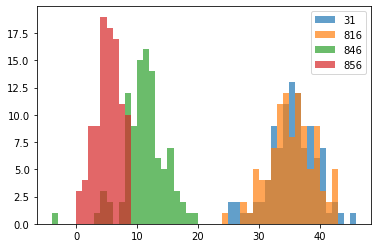

In [35]:
pm, mid = train_model(2000,dropout = 0.1)
t[mid],s[mid], e[mid] = eval_model(pm)
p[mid] = pm
save_model(p[mid], mid)
run_test(t[mid], s[mid], [31,816,846,856])

In [38]:
mid

'mlp-e2000-l10-10-5-student-d0.1'

In [27]:
t.keys()

dict_keys(['mlp-e500-l10-10-5-student-d0.1', 'mlp-e200-l32-16-8-4-student-d0.1', 'mlp-e2000-l10-10-5-student-d0.1', 'mlp-e200-l8-4-student-d0.1'])

INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 168.53it/s, avg_epoch_loss=1.43]
INFO:root:Epoch[0] Elapsed time 0.595 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=1.427053
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 168.04it/s, avg_epoch_loss=0.952]
INFO:root:Epoch[1] Elapsed time 0.597 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.952001
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 166.51it/s, avg_epoch_loss=0.659]
INFO:root:Epoch[2] Elapsed time 0.602 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.658649
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 166.97it/s, avg_epoch_loss=0.511]
INFO:root:Epoch[3] Elapsed time 0.601 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=0.511340
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 164.11it/

100%|██████████| 100/100 [00:00<00:00, 178.01it/s, avg_epoch_loss=0.0677]
INFO:root:Epoch[72] Elapsed time 0.563 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=0.067720
INFO:root:Epoch[73] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 174.91it/s, avg_epoch_loss=0.0683]
INFO:root:Epoch[73] Elapsed time 0.573 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=0.068348
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 177.70it/s, avg_epoch_loss=0.0819]
INFO:root:Epoch[74] Elapsed time 0.565 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=0.081872
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 175.35it/s, avg_epoch_loss=0.063]
INFO:root:Epoch[75] Elapsed time 0.572 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=0.062991
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 177.78it/s, avg_epoch_loss=0.0987]
INFO:root:Epoch[76] Ela

INFO:root:Epoch[108] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 179.80it/s, avg_epoch_loss=0.11]
INFO:root:Epoch[108] Elapsed time 0.558 seconds
INFO:root:Epoch[108] Evaluation metric 'epoch_loss'=0.110125
INFO:root:Epoch[109] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 176.37it/s, avg_epoch_loss=0.0745]
INFO:root:Epoch[109] Elapsed time 0.569 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=0.074518
INFO:root:Epoch[110] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 177.46it/s, avg_epoch_loss=0.0851]
INFO:root:Epoch[110] Elapsed time 0.565 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=0.085117
INFO:root:Epoch[111] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 176.70it/s, avg_epoch_loss=0.0668]
INFO:root:Epoch[111] Elapsed time 0.568 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=0.066834
INFO:root:Epoch[112] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:

INFO:root:Epoch[143] Evaluation metric 'epoch_loss'=0.069835
INFO:root:Epoch[144] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 176.82it/s, avg_epoch_loss=0.0848]
INFO:root:Epoch[144] Elapsed time 0.567 seconds
INFO:root:Epoch[144] Evaluation metric 'epoch_loss'=0.084804
INFO:root:Epoch[145] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 175.60it/s, avg_epoch_loss=0.0718]
INFO:root:Epoch[145] Elapsed time 0.571 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=0.071785
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 177.70it/s, avg_epoch_loss=0.0595]
INFO:root:Epoch[146] Elapsed time 0.565 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=0.059527
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 175.62it/s, avg_epoch_loss=0.059]
INFO:root:Epoch[147] Elapsed time 0.571 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=0.058996
INFO:root:Epoch[148] Learning ra

INFO:root:Epoch[180] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 151.82it/s, avg_epoch_loss=0.0862]
INFO:root:Epoch[180] Elapsed time 0.661 seconds
INFO:root:Epoch[180] Evaluation metric 'epoch_loss'=0.086174
INFO:root:Epoch[181] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 157.88it/s, avg_epoch_loss=0.0735]
INFO:root:Epoch[181] Elapsed time 0.635 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=0.073531
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 181.54it/s, avg_epoch_loss=0.0769]
INFO:root:Epoch[182] Elapsed time 0.553 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=0.076940
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.50it/s, avg_epoch_loss=0.0855]
INFO:root:Epoch[183] Elapsed time 0.559 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=0.085525
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 176.55it/

{
    "MSE": 0.14338395884529645,
    "abs_error": 1039.5928681634666,
    "abs_target_sum": 3083.21469670675,
    "abs_target_mean": 0.8475026653949286,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.5329771302418725,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 477.57492457970125,
    "Coverage[0.1]": 0.1858163826278175,
    "QuantileLoss[0.5]": 1039.5928681634666,
    "Coverage[0.5]": 0.5728422210005497,
    "QuantileLoss[0.9]": 593.6251955364994,
    "Coverage[0.9]": 0.820505772402419,
    "RMSE": 0.3786607437341458,
    "NRMSE": 0.4467959325622809,
    "ND": 0.3371782280597841,
    "wQuantileLoss[0.1]": 0.15489512458856972,
    "wQuantileLoss[0.5]": 0.3371782280597841,
    "wQuantileLoss[0.9]": 0.19253449854483493,
    "mean_wQuantileLoss": 0.22820261706439626,
    "MAE_Coverage": 0.07938427707531609
}
idx: 31 t: 31 p: 34
idx: 816 t: 44 p: 33
idx: 846 t: 14 p: 10
idx: 856 t: 4 p: 2


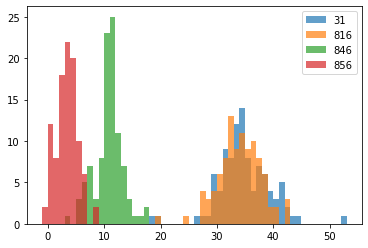

In [23]:
pm, mid = train_model(200,dropout = 0.1, layers=[8,4])
t[mid],s[mid], e[mid] = eval_model(pm)
p[mid] = pm
run_test(t[mid], s[mid], [31,816,846,856])

In [20]:
e={}

Running evaluation: 100%|██████████| 3638/3638 [00:20<00:00, 177.03it/s]


{
    "MSE": 0.1699824072874133,
    "abs_error": 1092.8193656709611,
    "abs_target_sum": 3083.21469670675,
    "abs_target_mean": 0.8475026653949286,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.5603963980811809,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 482.4253170157214,
    "Coverage[0.1]": 0.13936228697086311,
    "QuantileLoss[0.5]": 1092.8193656709611,
    "Coverage[0.5]": 0.47800989554700385,
    "QuantileLoss[0.9]": 649.2624782002611,
    "Coverage[0.9]": 0.8067619571192963,
    "RMSE": 0.4122892277120678,
    "NRMSE": 0.48647543488249056,
    "ND": 0.35444154013608775,
    "wQuantileLoss[0.1]": 0.156468285368194,
    "wQuantileLoss[0.5]": 0.35444154013608775,
    "wQuantileLoss[0.9]": 0.21057971697324634,
    "mean_wQuantileLoss": 0.24049651415917603,
    "MAE_Coverage": 0.05153014476818765
}
idx: 31 t: 31 p: 31
idx: 816 t: 44 p: 31
idx: 846 t: 14 p: 10
idx: 856 t: 4 p: 3


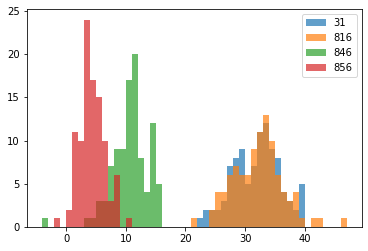

In [21]:
t[mid],s[mid], e[mid] = eval_model(pm)
p[mid] = pm
run_test(t[mid], s[mid], [31,816,846,856])

In [220]:
pm, mid = train_model(500, layers=[10,5])
t[mid],s[mid] = eval_model(pm)
p[mid] = pm

INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 196.36it/s, avg_epoch_loss=1.22]
INFO:root:Epoch[0] Elapsed time 0.511 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=1.215777
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 192.51it/s, avg_epoch_loss=0.405]
INFO:root:Epoch[1] Elapsed time 0.521 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.405416
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 166.39it/s, avg_epoch_loss=0.0627]
INFO:root:Epoch[2] Elapsed time 0.602 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.062685
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 196.71it/s, avg_epoch_loss=-.0138]
INFO:root:Epoch[3] Elapsed time 0.510 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=-0.013815
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 197.39

100%|██████████| 100/100 [00:00<00:00, 195.15it/s, avg_epoch_loss=-.109]
INFO:root:Epoch[36] Elapsed time 0.514 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=-0.108623
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 199.92it/s, avg_epoch_loss=-.121]
INFO:root:Epoch[37] Elapsed time 0.502 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=-0.120859
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 199.60it/s, avg_epoch_loss=-.122]
INFO:root:Epoch[38] Elapsed time 0.502 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=-0.121565
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 193.65it/s, avg_epoch_loss=-.122]
INFO:root:Epoch[39] Elapsed time 0.518 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=-0.122051
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 195.68it/s, avg_epoch_loss=-.0931]
INFO:root:Epoch[40] Elapsed ti

INFO:root:Epoch[107] Evaluation metric 'epoch_loss'=-0.134551
INFO:root:Epoch[108] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 190.20it/s, avg_epoch_loss=-.102]
INFO:root:Epoch[108] Elapsed time 0.527 seconds
INFO:root:Epoch[108] Evaluation metric 'epoch_loss'=-0.101836
INFO:root:Epoch[109] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 187.11it/s, avg_epoch_loss=-.115]
INFO:root:Epoch[109] Elapsed time 0.536 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=-0.115406
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 187.09it/s, avg_epoch_loss=-.129]
INFO:root:Epoch[110] Elapsed time 0.536 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=-0.129130
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 189.49it/s, avg_epoch_loss=-.128]
INFO:root:Epoch[111] Elapsed time 0.529 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=-0.128102
INFO:root:Epoch[112] Learning 

INFO:root:Epoch[144] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 176.28it/s, avg_epoch_loss=-.14]
INFO:root:Epoch[144] Elapsed time 0.569 seconds
INFO:root:Epoch[144] Evaluation metric 'epoch_loss'=-0.140077
INFO:root:Epoch[145] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 178.00it/s, avg_epoch_loss=-.108]
INFO:root:Epoch[145] Elapsed time 0.563 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=-0.107636
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.19it/s, avg_epoch_loss=-.126]
INFO:root:Epoch[146] Elapsed time 0.580 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=-0.126387
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 190.18it/s, avg_epoch_loss=-.103]
INFO:root:Epoch[147] Elapsed time 0.527 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=-0.103117
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 191.79it/s

100%|██████████| 100/100 [00:00<00:00, 205.17it/s, avg_epoch_loss=-.139]
INFO:root:Epoch[180] Elapsed time 0.489 seconds
INFO:root:Epoch[180] Evaluation metric 'epoch_loss'=-0.138800
INFO:root:Epoch[181] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 207.56it/s, avg_epoch_loss=-.105]
INFO:root:Epoch[181] Elapsed time 0.483 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=-0.105065
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 204.21it/s, avg_epoch_loss=-.112]
INFO:root:Epoch[182] Elapsed time 0.491 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=-0.111730
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 209.53it/s, avg_epoch_loss=-.131]
INFO:root:Epoch[183] Elapsed time 0.479 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=-0.131185
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 207.15it/s, avg_epoch_loss=-.129]
INFO:root:Epoch[184

100%|██████████| 100/100 [00:00<00:00, 186.32it/s, avg_epoch_loss=-.11]
INFO:root:Epoch[252] Elapsed time 0.538 seconds
INFO:root:Epoch[252] Evaluation metric 'epoch_loss'=-0.109518
INFO:root:Epoch[253] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 187.10it/s, avg_epoch_loss=-.139]
INFO:root:Epoch[253] Elapsed time 0.536 seconds
INFO:root:Epoch[253] Evaluation metric 'epoch_loss'=-0.139240
INFO:root:Epoch[254] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 187.38it/s, avg_epoch_loss=-.107]
INFO:root:Epoch[254] Elapsed time 0.535 seconds
INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=-0.107293
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 184.73it/s, avg_epoch_loss=-.114]
INFO:root:Epoch[255] Elapsed time 0.543 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=-0.114403
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 185.85it/s, avg_epoch_loss=-.132]
INFO:root:Epoch[256]

100%|██████████| 100/100 [00:00<00:00, 195.47it/s, avg_epoch_loss=-.126]
INFO:root:Epoch[324] Elapsed time 0.513 seconds
INFO:root:Epoch[324] Evaluation metric 'epoch_loss'=-0.125644
INFO:root:Epoch[325] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 192.08it/s, avg_epoch_loss=-.111]
INFO:root:Epoch[325] Elapsed time 0.522 seconds
INFO:root:Epoch[325] Evaluation metric 'epoch_loss'=-0.111029
INFO:root:Epoch[326] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 192.60it/s, avg_epoch_loss=-.14]
INFO:root:Epoch[326] Elapsed time 0.521 seconds
INFO:root:Epoch[326] Evaluation metric 'epoch_loss'=-0.140301
INFO:root:Epoch[327] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 195.81it/s, avg_epoch_loss=-.108]
INFO:root:Epoch[327] Elapsed time 0.512 seconds
INFO:root:Epoch[327] Evaluation metric 'epoch_loss'=-0.108004
INFO:root:Epoch[328] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 198.81it/s, avg_epoch_loss=-.116]
INFO:root:Epoch[328]

100%|██████████| 100/100 [00:00<00:00, 181.27it/s, avg_epoch_loss=-.133]
INFO:root:Epoch[396] Elapsed time 0.553 seconds
INFO:root:Epoch[396] Evaluation metric 'epoch_loss'=-0.133052
INFO:root:Epoch[397] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 154.92it/s, avg_epoch_loss=-.126]
INFO:root:Epoch[397] Elapsed time 0.647 seconds
INFO:root:Epoch[397] Evaluation metric 'epoch_loss'=-0.126193
INFO:root:Epoch[398] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 169.03it/s, avg_epoch_loss=-.112]
INFO:root:Epoch[398] Elapsed time 0.596 seconds
INFO:root:Epoch[398] Evaluation metric 'epoch_loss'=-0.111709
INFO:root:Epoch[399] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 181.13it/s, avg_epoch_loss=-.141]
INFO:root:Epoch[399] Elapsed time 0.554 seconds
INFO:root:Epoch[399] Evaluation metric 'epoch_loss'=-0.141110
INFO:root:Epoch[400] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 193.25it/s, avg_epoch_loss=-.109]
INFO:root:Epoch[400

100%|██████████| 100/100 [00:00<00:00, 210.04it/s, avg_epoch_loss=-.124]
INFO:root:Epoch[468] Elapsed time 0.477 seconds
INFO:root:Epoch[468] Evaluation metric 'epoch_loss'=-0.123678
INFO:root:Epoch[469] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 203.81it/s, avg_epoch_loss=-.132]
INFO:root:Epoch[469] Elapsed time 0.492 seconds
INFO:root:Epoch[469] Evaluation metric 'epoch_loss'=-0.131847
INFO:root:Epoch[470] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 205.16it/s, avg_epoch_loss=-.129]
INFO:root:Epoch[470] Elapsed time 0.489 seconds
INFO:root:Epoch[470] Evaluation metric 'epoch_loss'=-0.129257
INFO:root:Epoch[471] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 205.08it/s, avg_epoch_loss=-.113]
INFO:root:Epoch[471] Elapsed time 0.489 seconds
INFO:root:Epoch[471] Evaluation metric 'epoch_loss'=-0.113152
INFO:root:Epoch[472] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 204.11it/s, avg_epoch_loss=-.143]
INFO:root:Epoch[472

{
    "MSE": 0.3086568233792749,
    "abs_error": 1585.2765641315914,
    "abs_target_sum": 3677.5622829723397,
    "abs_target_mean": 1.0108747341870092,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.6669529076483897,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 603.7919668483962,
    "Coverage[0.1]": 0.049752611324903794,
    "QuantileLoss[0.5]": 1585.2765641315914,
    "Coverage[0.5]": 0.13551401869158877,
    "QuantileLoss[0.9]": 1493.2853354795673,
    "Coverage[0.9]": 0.3633864760857614,
    "RMSE": 0.55556891865841,
    "NRMSE": 0.5495922490388716,
    "ND": 0.4310672239248422,
    "wQuantileLoss[0.1]": 0.16418266242397656,
    "wQuantileLoss[0.5]": 0.4310672239248422,
    "wQuantileLoss[0.9]": 0.40605303746824367,
    "mean_wQuantileLoss": 0.3337676412723541,
    "MAE_Coverage": 0.3171156312992487
}


In [221]:
pm, mid = train_model(500, layers=[32,16,8,4])
t[mid],s[mid] = eval_model(pm)
p[mid] = pm

INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 160.67it/s, avg_epoch_loss=0.726]
INFO:root:Epoch[0] Elapsed time 0.624 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=0.725802
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 164.55it/s, avg_epoch_loss=0.00447]
INFO:root:Epoch[1] Elapsed time 0.609 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.004470
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 166.78it/s, avg_epoch_loss=-.0506]
INFO:root:Epoch[2] Elapsed time 0.601 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=-0.050599
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 170.83it/s, avg_epoch_loss=-.0707]
INFO:root:Epoch[3] Elapsed time 0.587 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=-0.070750
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 16

100%|██████████| 100/100 [00:00<00:00, 153.30it/s, avg_epoch_loss=-.137]
INFO:root:Epoch[36] Elapsed time 0.654 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=-0.136878
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 157.84it/s, avg_epoch_loss=-.149]
INFO:root:Epoch[37] Elapsed time 0.635 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=-0.148723
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 157.86it/s, avg_epoch_loss=-.141]
INFO:root:Epoch[38] Elapsed time 0.635 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=-0.141253
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 158.23it/s, avg_epoch_loss=-.155]
INFO:root:Epoch[39] Elapsed time 0.634 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=-0.154900
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 126.93it/s, avg_epoch_loss=-.121]
INFO:root:Epoch[40] Elapsed tim

INFO:root:Epoch[107] Evaluation metric 'epoch_loss'=-0.173011
INFO:root:Epoch[108] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 151.17it/s, avg_epoch_loss=-.143]
INFO:root:Epoch[108] Elapsed time 0.663 seconds
INFO:root:Epoch[108] Evaluation metric 'epoch_loss'=-0.143384
INFO:root:Epoch[109] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 146.96it/s, avg_epoch_loss=-.155]
INFO:root:Epoch[109] Elapsed time 0.682 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=-0.155437
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 144.58it/s, avg_epoch_loss=-.163]
INFO:root:Epoch[110] Elapsed time 0.693 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=-0.163237
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 147.08it/s, avg_epoch_loss=-.165]
INFO:root:Epoch[111] Elapsed time 0.681 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=-0.164873
INFO:root:Epoch[112] Learning 

INFO:root:Epoch[144] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.06it/s, avg_epoch_loss=-.175]
INFO:root:Epoch[144] Elapsed time 0.611 seconds
INFO:root:Epoch[144] Evaluation metric 'epoch_loss'=-0.175020
INFO:root:Epoch[145] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 167.86it/s, avg_epoch_loss=-.146]
INFO:root:Epoch[145] Elapsed time 0.597 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=-0.145581
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.42it/s, avg_epoch_loss=-.161]
INFO:root:Epoch[146] Elapsed time 0.610 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=-0.161470
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.65it/s, avg_epoch_loss=-.143]
INFO:root:Epoch[147] Elapsed time 0.616 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=-0.142723
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.98it/

100%|██████████| 100/100 [00:00<00:00, 174.75it/s, avg_epoch_loss=-.177]
INFO:root:Epoch[180] Elapsed time 0.574 seconds
INFO:root:Epoch[180] Evaluation metric 'epoch_loss'=-0.176804
INFO:root:Epoch[181] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 175.10it/s, avg_epoch_loss=-.147]
INFO:root:Epoch[181] Elapsed time 0.572 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=-0.147252
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.22it/s, avg_epoch_loss=-.152]
INFO:root:Epoch[182] Elapsed time 0.578 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=-0.151850
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.58it/s, avg_epoch_loss=-.166]
INFO:root:Epoch[183] Elapsed time 0.577 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=-0.165696
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 172.69it/s, avg_epoch_loss=-.167]
INFO:root:Epoch[184

100%|██████████| 100/100 [00:00<00:00, 170.27it/s, avg_epoch_loss=-.146]
INFO:root:Epoch[252] Elapsed time 0.589 seconds
INFO:root:Epoch[252] Evaluation metric 'epoch_loss'=-0.145553
INFO:root:Epoch[253] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.31it/s, avg_epoch_loss=-.178]
INFO:root:Epoch[253] Elapsed time 0.603 seconds
INFO:root:Epoch[253] Evaluation metric 'epoch_loss'=-0.177522
INFO:root:Epoch[254] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 174.25it/s, avg_epoch_loss=-.149]
INFO:root:Epoch[254] Elapsed time 0.575 seconds
INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=-0.148904
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 172.17it/s, avg_epoch_loss=-.154]
INFO:root:Epoch[255] Elapsed time 0.582 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=-0.154066
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.41it/s, avg_epoch_loss=-.167]
INFO:root:Epoch[256

100%|██████████| 100/100 [00:00<00:00, 175.39it/s, avg_epoch_loss=-.162]
INFO:root:Epoch[324] Elapsed time 0.571 seconds
INFO:root:Epoch[324] Evaluation metric 'epoch_loss'=-0.161508
INFO:root:Epoch[325] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 175.99it/s, avg_epoch_loss=-.148]
INFO:root:Epoch[325] Elapsed time 0.570 seconds
INFO:root:Epoch[325] Evaluation metric 'epoch_loss'=-0.147994
INFO:root:Epoch[326] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 177.24it/s, avg_epoch_loss=-.179]
INFO:root:Epoch[326] Elapsed time 0.565 seconds
INFO:root:Epoch[326] Evaluation metric 'epoch_loss'=-0.179328
INFO:root:Epoch[327] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 172.32it/s, avg_epoch_loss=-.149]
INFO:root:Epoch[327] Elapsed time 0.582 seconds
INFO:root:Epoch[327] Evaluation metric 'epoch_loss'=-0.148606
INFO:root:Epoch[328] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 178.53it/s, avg_epoch_loss=-.155]
INFO:root:Epoch[328

100%|██████████| 100/100 [00:00<00:00, 155.44it/s, avg_epoch_loss=-.172]
INFO:root:Epoch[396] Elapsed time 0.645 seconds
INFO:root:Epoch[396] Evaluation metric 'epoch_loss'=-0.171594
INFO:root:Epoch[397] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.93it/s, avg_epoch_loss=-.163]
INFO:root:Epoch[397] Elapsed time 0.611 seconds
INFO:root:Epoch[397] Evaluation metric 'epoch_loss'=-0.163440
INFO:root:Epoch[398] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.42it/s, avg_epoch_loss=-.149]
INFO:root:Epoch[398] Elapsed time 0.613 seconds
INFO:root:Epoch[398] Evaluation metric 'epoch_loss'=-0.149108
INFO:root:Epoch[399] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.82it/s, avg_epoch_loss=-.179]
INFO:root:Epoch[399] Elapsed time 0.612 seconds
INFO:root:Epoch[399] Evaluation metric 'epoch_loss'=-0.179186
INFO:root:Epoch[400] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.35it/s, avg_epoch_loss=-.151]
INFO:root:Epoch[400

100%|██████████| 100/100 [00:00<00:00, 154.76it/s, avg_epoch_loss=-.163]
INFO:root:Epoch[468] Elapsed time 0.648 seconds
INFO:root:Epoch[468] Evaluation metric 'epoch_loss'=-0.163091
INFO:root:Epoch[469] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 157.24it/s, avg_epoch_loss=-.171]
INFO:root:Epoch[469] Elapsed time 0.638 seconds
INFO:root:Epoch[469] Evaluation metric 'epoch_loss'=-0.170660
INFO:root:Epoch[470] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 159.22it/s, avg_epoch_loss=-.166]
INFO:root:Epoch[470] Elapsed time 0.630 seconds
INFO:root:Epoch[470] Evaluation metric 'epoch_loss'=-0.166068
INFO:root:Epoch[471] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 156.88it/s, avg_epoch_loss=-.151]
INFO:root:Epoch[471] Elapsed time 0.639 seconds
INFO:root:Epoch[471] Evaluation metric 'epoch_loss'=-0.150666
INFO:root:Epoch[472] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 171.99it/s, avg_epoch_loss=-.181]
INFO:root:Epoch[472

{
    "MSE": 0.2981205094327549,
    "abs_error": 1540.1938594877683,
    "abs_target_sum": 3677.5622829723397,
    "abs_target_mean": 1.0108747341870092,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.6685573749687055,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 613.0507080137261,
    "Coverage[0.1]": 0.06926882902693787,
    "QuantileLoss[0.5]": 1540.1938594877683,
    "Coverage[0.5]": 0.15228147333699835,
    "QuantileLoss[0.9]": 1455.6545566663103,
    "Coverage[0.9]": 0.38235294117647056,
    "RMSE": 0.5460041295015587,
    "NRMSE": 0.5401303554596008,
    "ND": 0.4188083684181489,
    "wQuantileLoss[0.1]": 0.166700292433453,
    "wQuantileLoss[0.5]": 0.4188083684181489,
    "wQuantileLoss[0.9]": 0.3958205040894093,
    "mean_wQuantileLoss": 0.32710972164700375,
    "MAE_Coverage": 0.2986989188198644
}


idx: 31 t: 31 p: 30
idx: 816 t: 44 p: 30
idx: 846 t: 14 p: 9
idx: 856 t: 4 p: 0


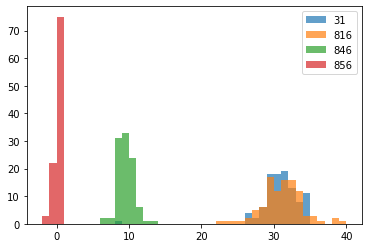

In [222]:
run_test(t[mid], s[mid], [31,816,846,856])

INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 151.69it/s, avg_epoch_loss=0.744]
INFO:root:Epoch[0] Elapsed time 0.661 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=0.744444
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 155.05it/s, avg_epoch_loss=-.0131]
INFO:root:Epoch[1] Elapsed time 0.647 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=-0.013148
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 160.36it/s, avg_epoch_loss=-.0564]
INFO:root:Epoch[2] Elapsed time 0.625 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=-0.056399
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 164.27it/s, avg_epoch_loss=-.0788]
INFO:root:Epoch[3] Elapsed time 0.611 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=-0.078842
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 16

100%|██████████| 100/100 [00:00<00:00, 129.19it/s, avg_epoch_loss=-.118]
INFO:root:Epoch[36] Elapsed time 0.776 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=-0.118323
INFO:root:Loading parameters from best epoch (26)
INFO:root:Epoch[37] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 122.46it/s, avg_epoch_loss=-.146]
INFO:root:Epoch[37] Elapsed time 0.819 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=-0.146161
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 132.64it/s, avg_epoch_loss=-.141]
INFO:root:Epoch[38] Elapsed time 0.756 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=-0.141033
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 132.84it/s, avg_epoch_loss=-.143]
INFO:root:Epoch[39] Elapsed time 0.755 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=-0.143484
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 138.84it/s,

INFO:root:Epoch[72] Learning rate is 0.000125
100%|██████████| 100/100 [00:00<00:00, 139.77it/s, avg_epoch_loss=-.127]
INFO:root:Epoch[72] Elapsed time 0.717 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=-0.126734
INFO:root:Epoch[73] Learning rate is 0.000125
100%|██████████| 100/100 [00:00<00:00, 149.63it/s, avg_epoch_loss=-.15]
INFO:root:Epoch[73] Elapsed time 0.671 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=-0.150051
INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 100/100 [00:00<00:00, 144.19it/s, avg_epoch_loss=-.125]
INFO:root:Epoch[74] Elapsed time 0.696 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=-0.125077
INFO:root:Loading parameters from best epoch (54)
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 137.50it/s, avg_epoch_loss=-.146]
INFO:root:Epoch[75] Elapsed time 0.729 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=-0.146120
INFO:root:Epoch[76] Learning rate is 6.25e-

INFO:root:Epoch[108] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.37it/s, avg_epoch_loss=-.13]
INFO:root:Epoch[108] Elapsed time 0.614 seconds
INFO:root:Epoch[108] Evaluation metric 'epoch_loss'=-0.130010
INFO:root:Epoch[109] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.89it/s, avg_epoch_loss=-.142]
INFO:root:Epoch[109] Elapsed time 0.620 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=-0.141545
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.76it/s, avg_epoch_loss=-.157]
INFO:root:Epoch[110] Elapsed time 0.610 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=-0.156631
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.81it/s, avg_epoch_loss=-.151]
INFO:root:Epoch[111] Elapsed time 0.609 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=-0.151004
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.58it/s

100%|██████████| 100/100 [00:00<00:00, 163.44it/s, avg_epoch_loss=-.166]
INFO:root:Epoch[144] Elapsed time 0.613 seconds
INFO:root:Epoch[144] Evaluation metric 'epoch_loss'=-0.165842
INFO:root:Epoch[145] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 159.92it/s, avg_epoch_loss=-.132]
INFO:root:Epoch[145] Elapsed time 0.627 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=-0.131967
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 155.64it/s, avg_epoch_loss=-.15]
INFO:root:Epoch[146] Elapsed time 0.644 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=-0.149525
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 159.57it/s, avg_epoch_loss=-.129]
INFO:root:Epoch[147] Elapsed time 0.628 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=-0.129244
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.49it/s, avg_epoch_loss=-.15]
INFO:root:Epoch[148] 

100%|██████████| 100/100 [00:00<00:00, 164.53it/s, avg_epoch_loss=-.155]
INFO:root:Epoch[216] Elapsed time 0.609 seconds
INFO:root:Epoch[216] Evaluation metric 'epoch_loss'=-0.154728
INFO:root:Epoch[217] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.80it/s, avg_epoch_loss=-.165]
INFO:root:Epoch[217] Elapsed time 0.612 seconds
INFO:root:Epoch[217] Evaluation metric 'epoch_loss'=-0.165132
INFO:root:Epoch[218] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.88it/s, avg_epoch_loss=-.135]
INFO:root:Epoch[218] Elapsed time 0.619 seconds
INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=-0.134682
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 159.97it/s, avg_epoch_loss=-.147]
INFO:root:Epoch[219] Elapsed time 0.627 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=-0.146814
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.90it/s, avg_epoch_loss=-.135]
INFO:root:Epoch[220

100%|██████████| 100/100 [00:00<00:00, 169.58it/s, avg_epoch_loss=-.147]
INFO:root:Epoch[288] Elapsed time 0.591 seconds
INFO:root:Epoch[288] Evaluation metric 'epoch_loss'=-0.146738
INFO:root:Epoch[289] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.64it/s, avg_epoch_loss=-.154]
INFO:root:Epoch[289] Elapsed time 0.602 seconds
INFO:root:Epoch[289] Evaluation metric 'epoch_loss'=-0.154149
INFO:root:Epoch[290] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.84it/s, avg_epoch_loss=-.169]
INFO:root:Epoch[290] Elapsed time 0.587 seconds
INFO:root:Epoch[290] Evaluation metric 'epoch_loss'=-0.168930
INFO:root:Epoch[291] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 142.97it/s, avg_epoch_loss=-.136]
INFO:root:Epoch[291] Elapsed time 0.701 seconds
INFO:root:Epoch[291] Evaluation metric 'epoch_loss'=-0.135642
INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 152.59it/s, avg_epoch_loss=-.147]
INFO:root:Epoch[292

100%|██████████| 100/100 [00:00<00:00, 134.73it/s, avg_epoch_loss=-.134]
INFO:root:Epoch[360] Elapsed time 0.744 seconds
INFO:root:Epoch[360] Evaluation metric 'epoch_loss'=-0.134442
INFO:root:Epoch[361] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 134.79it/s, avg_epoch_loss=-.149]
INFO:root:Epoch[361] Elapsed time 0.744 seconds
INFO:root:Epoch[361] Evaluation metric 'epoch_loss'=-0.148676
INFO:root:Epoch[362] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 143.40it/s, avg_epoch_loss=-.159]
INFO:root:Epoch[362] Elapsed time 0.699 seconds
INFO:root:Epoch[362] Evaluation metric 'epoch_loss'=-0.158555
INFO:root:Epoch[363] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.81it/s, avg_epoch_loss=-.166]
INFO:root:Epoch[363] Elapsed time 0.619 seconds
INFO:root:Epoch[363] Evaluation metric 'epoch_loss'=-0.166175
INFO:root:Epoch[364] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.99it/s, avg_epoch_loss=-.137]
INFO:root:Epoch[364

100%|██████████| 100/100 [00:00<00:00, 162.95it/s, avg_epoch_loss=-.153]
INFO:root:Epoch[432] Elapsed time 0.615 seconds
INFO:root:Epoch[432] Evaluation metric 'epoch_loss'=-0.152699
INFO:root:Epoch[433] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.79it/s, avg_epoch_loss=-.135]
INFO:root:Epoch[433] Elapsed time 0.616 seconds
INFO:root:Epoch[433] Evaluation metric 'epoch_loss'=-0.134671
INFO:root:Epoch[434] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.93it/s, avg_epoch_loss=-.148]
INFO:root:Epoch[434] Elapsed time 0.615 seconds
INFO:root:Epoch[434] Evaluation metric 'epoch_loss'=-0.148142
INFO:root:Epoch[435] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.96it/s, avg_epoch_loss=-.16]
INFO:root:Epoch[435] Elapsed time 0.611 seconds
INFO:root:Epoch[435] Evaluation metric 'epoch_loss'=-0.159528
INFO:root:Epoch[436] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.49it/s, avg_epoch_loss=-.166]
INFO:root:Epoch[436]

100%|██████████| 100/100 [00:00<00:00, 167.76it/s, avg_epoch_loss=-.162]
INFO:root:Epoch[504] Elapsed time 0.597 seconds
INFO:root:Epoch[504] Evaluation metric 'epoch_loss'=-0.161754
INFO:root:Epoch[505] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 171.77it/s, avg_epoch_loss=-.153]
INFO:root:Epoch[505] Elapsed time 0.584 seconds
INFO:root:Epoch[505] Evaluation metric 'epoch_loss'=-0.153464
INFO:root:Epoch[506] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 167.36it/s, avg_epoch_loss=-.135]
INFO:root:Epoch[506] Elapsed time 0.599 seconds
INFO:root:Epoch[506] Evaluation metric 'epoch_loss'=-0.135222
INFO:root:Epoch[507] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 167.19it/s, avg_epoch_loss=-.15]
INFO:root:Epoch[507] Elapsed time 0.600 seconds
INFO:root:Epoch[507] Evaluation metric 'epoch_loss'=-0.150394
INFO:root:Epoch[508] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.50it/s, avg_epoch_loss=-.153]
INFO:root:Epoch[508]

100%|██████████| 100/100 [00:00<00:00, 162.52it/s, avg_epoch_loss=-.156]
INFO:root:Epoch[576] Elapsed time 0.617 seconds
INFO:root:Epoch[576] Evaluation metric 'epoch_loss'=-0.155931
INFO:root:Epoch[577] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.57it/s, avg_epoch_loss=-.162]
INFO:root:Epoch[577] Elapsed time 0.620 seconds
INFO:root:Epoch[577] Evaluation metric 'epoch_loss'=-0.162395
INFO:root:Epoch[578] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.03it/s, avg_epoch_loss=-.156]
INFO:root:Epoch[578] Elapsed time 0.623 seconds
INFO:root:Epoch[578] Evaluation metric 'epoch_loss'=-0.155987
INFO:root:Epoch[579] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.80it/s, avg_epoch_loss=-.133]
INFO:root:Epoch[579] Elapsed time 0.608 seconds
INFO:root:Epoch[579] Evaluation metric 'epoch_loss'=-0.133352
INFO:root:Epoch[580] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.22it/s, avg_epoch_loss=-.15]
INFO:root:Epoch[580]

100%|██████████| 100/100 [00:00<00:00, 162.73it/s, avg_epoch_loss=-.15]
INFO:root:Epoch[648] Elapsed time 0.617 seconds
INFO:root:Epoch[648] Evaluation metric 'epoch_loss'=-0.149649
INFO:root:Epoch[649] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.33it/s, avg_epoch_loss=-.162]
INFO:root:Epoch[649] Elapsed time 0.614 seconds
INFO:root:Epoch[649] Evaluation metric 'epoch_loss'=-0.161672
INFO:root:Epoch[650] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.21it/s, avg_epoch_loss=-.156]
INFO:root:Epoch[650] Elapsed time 0.614 seconds
INFO:root:Epoch[650] Evaluation metric 'epoch_loss'=-0.156486
INFO:root:Epoch[651] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.95it/s, avg_epoch_loss=-.164]
INFO:root:Epoch[651] Elapsed time 0.615 seconds
INFO:root:Epoch[651] Evaluation metric 'epoch_loss'=-0.163884
INFO:root:Epoch[652] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 160.56it/s, avg_epoch_loss=-.131]
INFO:root:Epoch[652]

100%|██████████| 100/100 [00:00<00:00, 167.74it/s, avg_epoch_loss=-.138]
INFO:root:Epoch[720] Elapsed time 0.598 seconds
INFO:root:Epoch[720] Evaluation metric 'epoch_loss'=-0.137696
INFO:root:Epoch[721] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.65it/s, avg_epoch_loss=-.151]
INFO:root:Epoch[721] Elapsed time 0.601 seconds
INFO:root:Epoch[721] Evaluation metric 'epoch_loss'=-0.150797
INFO:root:Epoch[722] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.72it/s, avg_epoch_loss=-.16]
INFO:root:Epoch[722] Elapsed time 0.605 seconds
INFO:root:Epoch[722] Evaluation metric 'epoch_loss'=-0.160288
INFO:root:Epoch[723] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.57it/s, avg_epoch_loss=-.157]
INFO:root:Epoch[723] Elapsed time 0.605 seconds
INFO:root:Epoch[723] Evaluation metric 'epoch_loss'=-0.157341
INFO:root:Epoch[724] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.67it/s, avg_epoch_loss=-.162]
INFO:root:Epoch[724]

100%|██████████| 100/100 [00:00<00:00, 148.69it/s, avg_epoch_loss=-.17]
INFO:root:Epoch[792] Elapsed time 0.674 seconds
INFO:root:Epoch[792] Evaluation metric 'epoch_loss'=-0.169609
INFO:root:Epoch[793] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 154.30it/s, avg_epoch_loss=-.141]
INFO:root:Epoch[793] Elapsed time 0.650 seconds
INFO:root:Epoch[793] Evaluation metric 'epoch_loss'=-0.140594
INFO:root:Epoch[794] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 155.85it/s, avg_epoch_loss=-.146]
INFO:root:Epoch[794] Elapsed time 0.643 seconds
INFO:root:Epoch[794] Evaluation metric 'epoch_loss'=-0.145628
INFO:root:Epoch[795] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 157.35it/s, avg_epoch_loss=-.163]
INFO:root:Epoch[795] Elapsed time 0.637 seconds
INFO:root:Epoch[795] Evaluation metric 'epoch_loss'=-0.162753
INFO:root:Epoch[796] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 157.88it/s, avg_epoch_loss=-.16]
INFO:root:Epoch[796] 

100%|██████████| 100/100 [00:00<00:00, 171.02it/s, avg_epoch_loss=-.136]
INFO:root:Epoch[864] Elapsed time 0.586 seconds
INFO:root:Epoch[864] Evaluation metric 'epoch_loss'=-0.136159
INFO:root:Epoch[865] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 169.79it/s, avg_epoch_loss=-.172]
INFO:root:Epoch[865] Elapsed time 0.591 seconds
INFO:root:Epoch[865] Evaluation metric 'epoch_loss'=-0.172061
INFO:root:Epoch[866] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.94it/s, avg_epoch_loss=-.14]
INFO:root:Epoch[866] Elapsed time 0.587 seconds
INFO:root:Epoch[866] Evaluation metric 'epoch_loss'=-0.140270
INFO:root:Epoch[867] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.64it/s, avg_epoch_loss=-.149]
INFO:root:Epoch[867] Elapsed time 0.587 seconds
INFO:root:Epoch[867] Evaluation metric 'epoch_loss'=-0.149294
INFO:root:Epoch[868] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.26it/s, avg_epoch_loss=-.162]
INFO:root:Epoch[868]

100%|██████████| 100/100 [00:00<00:00, 177.94it/s, avg_epoch_loss=-.156]
INFO:root:Epoch[936] Elapsed time 0.563 seconds
INFO:root:Epoch[936] Evaluation metric 'epoch_loss'=-0.156283
INFO:root:Epoch[937] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.87it/s, avg_epoch_loss=-.141]
INFO:root:Epoch[937] Elapsed time 0.587 seconds
INFO:root:Epoch[937] Evaluation metric 'epoch_loss'=-0.140557
INFO:root:Epoch[938] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 172.92it/s, avg_epoch_loss=-.17]
INFO:root:Epoch[938] Elapsed time 0.580 seconds
INFO:root:Epoch[938] Evaluation metric 'epoch_loss'=-0.170458
INFO:root:Epoch[939] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 155.54it/s, avg_epoch_loss=-.142]
INFO:root:Epoch[939] Elapsed time 0.644 seconds
INFO:root:Epoch[939] Evaluation metric 'epoch_loss'=-0.141963
INFO:root:Epoch[940] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 160.16it/s, avg_epoch_loss=-.148]
INFO:root:Epoch[940]

100%|██████████| 100/100 [00:00<00:00, 179.04it/s, avg_epoch_loss=-.165]
INFO:root:Epoch[1008] Elapsed time 0.560 seconds
INFO:root:Epoch[1008] Evaluation metric 'epoch_loss'=-0.165152
INFO:root:Epoch[1009] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 178.53it/s, avg_epoch_loss=-.158]
INFO:root:Epoch[1009] Elapsed time 0.561 seconds
INFO:root:Epoch[1009] Evaluation metric 'epoch_loss'=-0.157558
INFO:root:Epoch[1010] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.40it/s, avg_epoch_loss=-.14]
INFO:root:Epoch[1010] Elapsed time 0.588 seconds
INFO:root:Epoch[1010] Evaluation metric 'epoch_loss'=-0.140213
INFO:root:Epoch[1011] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 174.28it/s, avg_epoch_loss=-.17]
INFO:root:Epoch[1011] Elapsed time 0.575 seconds
INFO:root:Epoch[1011] Evaluation metric 'epoch_loss'=-0.170331
INFO:root:Epoch[1012] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 174.83it/s, avg_epoch_loss=-.143]
INFO:root

INFO:root:Epoch[1044] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 176.58it/s, avg_epoch_loss=-.158]
INFO:root:Epoch[1044] Elapsed time 0.568 seconds
INFO:root:Epoch[1044] Evaluation metric 'epoch_loss'=-0.158291
INFO:root:Epoch[1045] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 175.50it/s, avg_epoch_loss=-.138]
INFO:root:Epoch[1045] Elapsed time 0.571 seconds
INFO:root:Epoch[1045] Evaluation metric 'epoch_loss'=-0.137770
INFO:root:Epoch[1046] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 177.42it/s, avg_epoch_loss=-.153]
INFO:root:Epoch[1046] Elapsed time 0.565 seconds
INFO:root:Epoch[1046] Evaluation metric 'epoch_loss'=-0.153090
INFO:root:Epoch[1047] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 175.60it/s, avg_epoch_loss=-.165]
INFO:root:Epoch[1047] Elapsed time 0.571 seconds
INFO:root:Epoch[1047] Evaluation metric 'epoch_loss'=-0.164509
INFO:root:Epoch[1048] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:

INFO:root:Epoch[1079] Evaluation metric 'epoch_loss'=-0.143864
INFO:root:Epoch[1080] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 175.73it/s, avg_epoch_loss=-.153]
INFO:root:Epoch[1080] Elapsed time 0.570 seconds
INFO:root:Epoch[1080] Evaluation metric 'epoch_loss'=-0.153315
INFO:root:Epoch[1081] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 177.36it/s, avg_epoch_loss=-.164]
INFO:root:Epoch[1081] Elapsed time 0.565 seconds
INFO:root:Epoch[1081] Evaluation metric 'epoch_loss'=-0.163532
INFO:root:Epoch[1082] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.29it/s, avg_epoch_loss=-.16]
INFO:root:Epoch[1082] Elapsed time 0.559 seconds
INFO:root:Epoch[1082] Evaluation metric 'epoch_loss'=-0.159926
INFO:root:Epoch[1083] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.65it/s, avg_epoch_loss=-.141]
INFO:root:Epoch[1083] Elapsed time 0.558 seconds
INFO:root:Epoch[1083] Evaluation metric 'epoch_loss'=-0.141406
INFO:root:Epoch[10

INFO:root:Epoch[1151] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 177.42it/s, avg_epoch_loss=-.154]
INFO:root:Epoch[1151] Elapsed time 0.565 seconds
INFO:root:Epoch[1151] Evaluation metric 'epoch_loss'=-0.154298
INFO:root:Epoch[1152] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 176.55it/s, avg_epoch_loss=-.142]
INFO:root:Epoch[1152] Elapsed time 0.568 seconds
INFO:root:Epoch[1152] Evaluation metric 'epoch_loss'=-0.141611
INFO:root:Epoch[1153] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 176.78it/s, avg_epoch_loss=-.158]
INFO:root:Epoch[1153] Elapsed time 0.567 seconds
INFO:root:Epoch[1153] Evaluation metric 'epoch_loss'=-0.157516
INFO:root:Epoch[1154] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 177.57it/s, avg_epoch_loss=-.164]
INFO:root:Epoch[1154] Elapsed time 0.564 seconds
INFO:root:Epoch[1154] Evaluation metric 'epoch_loss'=-0.164316
INFO:root:Epoch[1155] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:

INFO:root:Epoch[1186] Evaluation metric 'epoch_loss'=-0.143167
INFO:root:Epoch[1187] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.19it/s, avg_epoch_loss=-.156]
INFO:root:Epoch[1187] Elapsed time 0.607 seconds
INFO:root:Epoch[1187] Evaluation metric 'epoch_loss'=-0.155680
INFO:root:Epoch[1188] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.43it/s, avg_epoch_loss=-.159]
INFO:root:Epoch[1188] Elapsed time 0.610 seconds
INFO:root:Epoch[1188] Evaluation metric 'epoch_loss'=-0.159061
INFO:root:Epoch[1189] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.67it/s, avg_epoch_loss=-.167]
INFO:root:Epoch[1189] Elapsed time 0.602 seconds
INFO:root:Epoch[1189] Evaluation metric 'epoch_loss'=-0.167089
INFO:root:Epoch[1190] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.96it/s, avg_epoch_loss=-.159]
INFO:root:Epoch[1190] Elapsed time 0.600 seconds
INFO:root:Epoch[1190] Evaluation metric 'epoch_loss'=-0.159254
INFO:root:Epoch[1

INFO:root:Epoch[1258] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 169.59it/s, avg_epoch_loss=-.17]
INFO:root:Epoch[1258] Elapsed time 0.591 seconds
INFO:root:Epoch[1258] Evaluation metric 'epoch_loss'=-0.170415
INFO:root:Epoch[1259] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 167.50it/s, avg_epoch_loss=-.141]
INFO:root:Epoch[1259] Elapsed time 0.599 seconds
INFO:root:Epoch[1259] Evaluation metric 'epoch_loss'=-0.140958
INFO:root:Epoch[1260] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.88it/s, avg_epoch_loss=-.154]
INFO:root:Epoch[1260] Elapsed time 0.600 seconds
INFO:root:Epoch[1260] Evaluation metric 'epoch_loss'=-0.154259
INFO:root:Epoch[1261] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.94it/s, avg_epoch_loss=-.164]
INFO:root:Epoch[1261] Elapsed time 0.604 seconds
INFO:root:Epoch[1261] Evaluation metric 'epoch_loss'=-0.164112
INFO:root:Epoch[1262] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:0

INFO:root:Epoch[1293] Evaluation metric 'epoch_loss'=-0.149352
INFO:root:Epoch[1294] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.21it/s, avg_epoch_loss=-.167]
INFO:root:Epoch[1294] Elapsed time 0.622 seconds
INFO:root:Epoch[1294] Evaluation metric 'epoch_loss'=-0.166779
INFO:root:Epoch[1295] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.20it/s, avg_epoch_loss=-.175]
INFO:root:Epoch[1295] Elapsed time 0.618 seconds
INFO:root:Epoch[1295] Evaluation metric 'epoch_loss'=-0.174944
INFO:root:Epoch[1296] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.00it/s, avg_epoch_loss=-.14]
INFO:root:Epoch[1296] Elapsed time 0.619 seconds
INFO:root:Epoch[1296] Evaluation metric 'epoch_loss'=-0.139976
INFO:root:Epoch[1297] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.58it/s, avg_epoch_loss=-.16]
INFO:root:Epoch[1297] Elapsed time 0.613 seconds
INFO:root:Epoch[1297] Evaluation metric 'epoch_loss'=-0.159749
INFO:root:Epoch[129

INFO:root:Epoch[1365] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 169.89it/s, avg_epoch_loss=-.149]
INFO:root:Epoch[1365] Elapsed time 0.590 seconds
INFO:root:Epoch[1365] Evaluation metric 'epoch_loss'=-0.148921
INFO:root:Epoch[1366] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 169.72it/s, avg_epoch_loss=-.15]
INFO:root:Epoch[1366] Elapsed time 0.591 seconds
INFO:root:Epoch[1366] Evaluation metric 'epoch_loss'=-0.150078
INFO:root:Epoch[1367] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 172.11it/s, avg_epoch_loss=-.167]
INFO:root:Epoch[1367] Elapsed time 0.583 seconds
INFO:root:Epoch[1367] Evaluation metric 'epoch_loss'=-0.167279
INFO:root:Epoch[1368] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 174.10it/s, avg_epoch_loss=-.174]
INFO:root:Epoch[1368] Elapsed time 0.576 seconds
INFO:root:Epoch[1368] Evaluation metric 'epoch_loss'=-0.174440
INFO:root:Epoch[1369] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:0

INFO:root:Epoch[1400] Evaluation metric 'epoch_loss'=-0.149565
INFO:root:Epoch[1401] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 171.37it/s, avg_epoch_loss=-.174]
INFO:root:Epoch[1401] Elapsed time 0.585 seconds
INFO:root:Epoch[1401] Evaluation metric 'epoch_loss'=-0.173614
INFO:root:Epoch[1402] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 172.84it/s, avg_epoch_loss=-.16]
INFO:root:Epoch[1402] Elapsed time 0.580 seconds
INFO:root:Epoch[1402] Evaluation metric 'epoch_loss'=-0.159558
INFO:root:Epoch[1403] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.78it/s, avg_epoch_loss=-.14]
INFO:root:Epoch[1403] Elapsed time 0.612 seconds
INFO:root:Epoch[1403] Evaluation metric 'epoch_loss'=-0.139798
INFO:root:Epoch[1404] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.51it/s, avg_epoch_loss=-.172]
INFO:root:Epoch[1404] Elapsed time 0.602 seconds
INFO:root:Epoch[1404] Evaluation metric 'epoch_loss'=-0.172118
INFO:root:Epoch[140

INFO:root:Epoch[1472] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 176.34it/s, avg_epoch_loss=-.147]
INFO:root:Epoch[1472] Elapsed time 0.568 seconds
INFO:root:Epoch[1472] Evaluation metric 'epoch_loss'=-0.147066
INFO:root:Epoch[1473] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 176.99it/s, avg_epoch_loss=-.149]
INFO:root:Epoch[1473] Elapsed time 0.566 seconds
INFO:root:Epoch[1473] Evaluation metric 'epoch_loss'=-0.149110
INFO:root:Epoch[1474] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 178.70it/s, avg_epoch_loss=-.174]
INFO:root:Epoch[1474] Elapsed time 0.561 seconds
INFO:root:Epoch[1474] Evaluation metric 'epoch_loss'=-0.173858
INFO:root:Epoch[1475] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 176.94it/s, avg_epoch_loss=-.159]
INFO:root:Epoch[1475] Elapsed time 0.567 seconds
INFO:root:Epoch[1475] Evaluation metric 'epoch_loss'=-0.159491
INFO:root:Epoch[1476] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:

INFO:root:Epoch[1507] Evaluation metric 'epoch_loss'=-0.161203
INFO:root:Epoch[1508] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 171.73it/s, avg_epoch_loss=-.157]
INFO:root:Epoch[1508] Elapsed time 0.584 seconds
INFO:root:Epoch[1508] Evaluation metric 'epoch_loss'=-0.156855
INFO:root:Epoch[1509] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 172.97it/s, avg_epoch_loss=-.169]
INFO:root:Epoch[1509] Elapsed time 0.579 seconds
INFO:root:Epoch[1509] Evaluation metric 'epoch_loss'=-0.169293
INFO:root:Epoch[1510] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.82it/s, avg_epoch_loss=-.157]
INFO:root:Epoch[1510] Elapsed time 0.577 seconds
INFO:root:Epoch[1510] Evaluation metric 'epoch_loss'=-0.156895
INFO:root:Epoch[1511] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.16it/s, avg_epoch_loss=-.143]
INFO:root:Epoch[1511] Elapsed time 0.579 seconds
INFO:root:Epoch[1511] Evaluation metric 'epoch_loss'=-0.143120
INFO:root:Epoch[1

INFO:root:Epoch[1579] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 175.33it/s, avg_epoch_loss=-.144]
INFO:root:Epoch[1579] Elapsed time 0.572 seconds
INFO:root:Epoch[1579] Evaluation metric 'epoch_loss'=-0.143618
INFO:root:Epoch[1580] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.38it/s, avg_epoch_loss=-.158]
INFO:root:Epoch[1580] Elapsed time 0.578 seconds
INFO:root:Epoch[1580] Evaluation metric 'epoch_loss'=-0.158008
INFO:root:Epoch[1581] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 175.79it/s, avg_epoch_loss=-.159]
INFO:root:Epoch[1581] Elapsed time 0.570 seconds
INFO:root:Epoch[1581] Evaluation metric 'epoch_loss'=-0.158537
INFO:root:Epoch[1582] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 174.69it/s, avg_epoch_loss=-.171]
INFO:root:Epoch[1582] Elapsed time 0.574 seconds
INFO:root:Epoch[1582] Evaluation metric 'epoch_loss'=-0.170916
INFO:root:Epoch[1583] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:

INFO:root:Epoch[1614] Evaluation metric 'epoch_loss'=-0.166157
INFO:root:Epoch[1615] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 177.95it/s, avg_epoch_loss=-.173]
INFO:root:Epoch[1615] Elapsed time 0.563 seconds
INFO:root:Epoch[1615] Evaluation metric 'epoch_loss'=-0.172956
INFO:root:Epoch[1616] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 178.11it/s, avg_epoch_loss=-.147]
INFO:root:Epoch[1616] Elapsed time 0.563 seconds
INFO:root:Epoch[1616] Evaluation metric 'epoch_loss'=-0.147273
INFO:root:Epoch[1617] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 176.63it/s, avg_epoch_loss=-.159]
INFO:root:Epoch[1617] Elapsed time 0.567 seconds
INFO:root:Epoch[1617] Evaluation metric 'epoch_loss'=-0.158894
INFO:root:Epoch[1618] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 175.40it/s, avg_epoch_loss=-.144]
INFO:root:Epoch[1618] Elapsed time 0.571 seconds
INFO:root:Epoch[1618] Evaluation metric 'epoch_loss'=-0.144318
INFO:root:Epoch[1

INFO:root:Epoch[1686] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 169.47it/s, avg_epoch_loss=-.155]
INFO:root:Epoch[1686] Elapsed time 0.592 seconds
INFO:root:Epoch[1686] Evaluation metric 'epoch_loss'=-0.154654
INFO:root:Epoch[1687] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 171.29it/s, avg_epoch_loss=-.164]
INFO:root:Epoch[1687] Elapsed time 0.585 seconds
INFO:root:Epoch[1687] Evaluation metric 'epoch_loss'=-0.164356
INFO:root:Epoch[1688] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.61it/s, avg_epoch_loss=-.175]
INFO:root:Epoch[1688] Elapsed time 0.587 seconds
INFO:root:Epoch[1688] Evaluation metric 'epoch_loss'=-0.174501
INFO:root:Epoch[1689] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 172.23it/s, avg_epoch_loss=-.145]
INFO:root:Epoch[1689] Elapsed time 0.582 seconds
INFO:root:Epoch[1689] Evaluation metric 'epoch_loss'=-0.145265
INFO:root:Epoch[1690] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:

INFO:root:Epoch[1721] Evaluation metric 'epoch_loss'=-0.169718
INFO:root:Epoch[1722] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 172.31it/s, avg_epoch_loss=-.158]
INFO:root:Epoch[1722] Elapsed time 0.582 seconds
INFO:root:Epoch[1722] Evaluation metric 'epoch_loss'=-0.158434
INFO:root:Epoch[1723] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 171.89it/s, avg_epoch_loss=-.147]
INFO:root:Epoch[1723] Elapsed time 0.583 seconds
INFO:root:Epoch[1723] Evaluation metric 'epoch_loss'=-0.147229
INFO:root:Epoch[1724] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 174.89it/s, avg_epoch_loss=-.167]
INFO:root:Epoch[1724] Elapsed time 0.573 seconds
INFO:root:Epoch[1724] Evaluation metric 'epoch_loss'=-0.166617
INFO:root:Epoch[1725] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 175.40it/s, avg_epoch_loss=-.145]
INFO:root:Epoch[1725] Elapsed time 0.571 seconds
INFO:root:Epoch[1725] Evaluation metric 'epoch_loss'=-0.145439
INFO:root:Epoch[1

INFO:root:Epoch[1793] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 176.56it/s, avg_epoch_loss=-.161]
INFO:root:Epoch[1793] Elapsed time 0.568 seconds
INFO:root:Epoch[1793] Evaluation metric 'epoch_loss'=-0.160715
INFO:root:Epoch[1794] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 174.31it/s, avg_epoch_loss=-.17]
INFO:root:Epoch[1794] Elapsed time 0.575 seconds
INFO:root:Epoch[1794] Evaluation metric 'epoch_loss'=-0.169827
INFO:root:Epoch[1795] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 174.53it/s, avg_epoch_loss=-.158]
INFO:root:Epoch[1795] Elapsed time 0.574 seconds
INFO:root:Epoch[1795] Evaluation metric 'epoch_loss'=-0.158129
INFO:root:Epoch[1796] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 174.41it/s, avg_epoch_loss=-.146]
INFO:root:Epoch[1796] Elapsed time 0.575 seconds
INFO:root:Epoch[1796] Evaluation metric 'epoch_loss'=-0.146026
INFO:root:Epoch[1797] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:0

INFO:root:Epoch[1828] Evaluation metric 'epoch_loss'=-0.154607
INFO:root:Epoch[1829] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.00it/s, avg_epoch_loss=-.171]
INFO:root:Epoch[1829] Elapsed time 0.560 seconds
INFO:root:Epoch[1829] Evaluation metric 'epoch_loss'=-0.171151
INFO:root:Epoch[1830] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 180.27it/s, avg_epoch_loss=-.156]
INFO:root:Epoch[1830] Elapsed time 0.556 seconds
INFO:root:Epoch[1830] Evaluation metric 'epoch_loss'=-0.155967
INFO:root:Epoch[1831] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 177.42it/s, avg_epoch_loss=-.152]
INFO:root:Epoch[1831] Elapsed time 0.565 seconds
INFO:root:Epoch[1831] Evaluation metric 'epoch_loss'=-0.152033
INFO:root:Epoch[1832] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 178.66it/s, avg_epoch_loss=-.154]
INFO:root:Epoch[1832] Elapsed time 0.561 seconds
INFO:root:Epoch[1832] Evaluation metric 'epoch_loss'=-0.153732
INFO:root:Epoch[1

INFO:root:Epoch[1900] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.81it/s, avg_epoch_loss=-.165]
INFO:root:Epoch[1900] Elapsed time 0.587 seconds
INFO:root:Epoch[1900] Evaluation metric 'epoch_loss'=-0.165180
INFO:root:Epoch[1901] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.35it/s, avg_epoch_loss=-.157]
INFO:root:Epoch[1901] Elapsed time 0.578 seconds
INFO:root:Epoch[1901] Evaluation metric 'epoch_loss'=-0.156583
INFO:root:Epoch[1902] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 176.01it/s, avg_epoch_loss=-.172]
INFO:root:Epoch[1902] Elapsed time 0.569 seconds
INFO:root:Epoch[1902] Evaluation metric 'epoch_loss'=-0.172139
INFO:root:Epoch[1903] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 177.34it/s, avg_epoch_loss=-.155]
INFO:root:Epoch[1903] Elapsed time 0.565 seconds
INFO:root:Epoch[1903] Evaluation metric 'epoch_loss'=-0.154714
INFO:root:Epoch[1904] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:

INFO:root:Epoch[1935] Evaluation metric 'epoch_loss'=-0.174191
INFO:root:Epoch[1936] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 175.82it/s, avg_epoch_loss=-.139]
INFO:root:Epoch[1936] Elapsed time 0.570 seconds
INFO:root:Epoch[1936] Evaluation metric 'epoch_loss'=-0.138661
INFO:root:Epoch[1937] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 176.40it/s, avg_epoch_loss=-.166]
INFO:root:Epoch[1937] Elapsed time 0.568 seconds
INFO:root:Epoch[1937] Evaluation metric 'epoch_loss'=-0.166183
INFO:root:Epoch[1938] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 176.05it/s, avg_epoch_loss=-.147]
INFO:root:Epoch[1938] Elapsed time 0.569 seconds
INFO:root:Epoch[1938] Evaluation metric 'epoch_loss'=-0.147190
INFO:root:Epoch[1939] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 176.69it/s, avg_epoch_loss=-.156]
INFO:root:Epoch[1939] Elapsed time 0.567 seconds
INFO:root:Epoch[1939] Evaluation metric 'epoch_loss'=-0.155846
INFO:root:Epoch[1

{
    "MSE": 0.31751540027196107,
    "abs_error": 1571.0797430936832,
    "abs_target_sum": 3677.5622829723397,
    "abs_target_mean": 1.0108747341870092,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.6705406314563174,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 702.7041251243791,
    "Coverage[0.1]": 0.07806487080813634,
    "QuantileLoss[0.5]": 1571.0797430936832,
    "Coverage[0.5]": 0.15722924683892248,
    "QuantileLoss[0.9]": 1469.68728661874,
    "Coverage[0.9]": 0.3925233644859813,
    "RMSE": 0.5634850488450968,
    "NRMSE": 0.5574232195033312,
    "ND": 0.42720683491018385,
    "wQuantileLoss[0.1]": 0.19107878291497704,
    "wQuantileLoss[0.5]": 0.42720683491018385,
    "wQuantileLoss[0.9]": 0.39963627357818265,
    "mean_wQuantileLoss": 0.3393072971344478,
    "MAE_Coverage": 0.29072750595565333
}
idx: 31 t: 31 p: 30
idx: 816 t: 44 p: 30
idx: 846 t: 14 p: 9
idx: 856 t: 4 p: 0


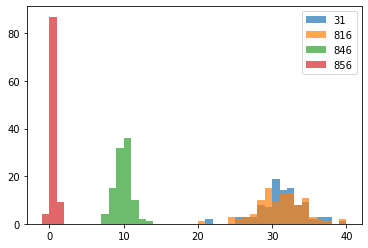

In [223]:
pm, mid = train_model(2000, layers=[32,16,8,4])
t[mid],s[mid] = eval_model(pm)
p[mid] = pm
run_test(t[mid], s[mid], [31,816,846,856])

### test

In [104]:
trec = next(iter(train_ds))
trec


{'target': array([1.46169051]), 'feat': array([-0.64173227, -1.57348481])}

idx: 31 t: 31 p: 30
idx: 816 t: 44 p: 29
idx: 846 t: 14 p: 6
idx: 856 t: 4 p: 0


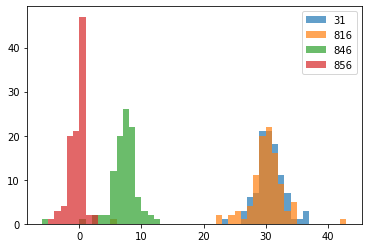

In [197]:
run_test(tss, forecasts, [31,816,846,856])

In [165]:
test_sel.iloc[816]

lap2nextpit      44.0
caution_laps      0.0
pitage            0.0
pit_oncaution     0.0
carno            12.0
eid               5.0
lap              49.0
stint_len        44.0
Name: 1077, dtype: float64

In [171]:
test_sel.iloc[836]

lap2nextpit      24.0
caution_laps     12.0
pitage           20.0
pit_oncaution     0.0
carno            12.0
eid               5.0
lap              69.0
stint_len        44.0
Name: 1097, dtype: float64

In [235]:
t[mid],s[mid] = eval_model(pm)

Running evaluation: 100%|██████████| 3638/3638 [00:17<00:00, 205.30it/s]

{
    "MSE": 0.6918114296565665,
    "abs_error": 2726.1717866286026,
    "abs_target_sum": 3677.5622829723397,
    "abs_target_mean": 1.0108747341870092,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.6370308383276133,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 2926.728351150853,
    "Coverage[0.1]": 0.44887300714678396,
    "QuantileLoss[0.5]": 2726.1717866286026,
    "Coverage[0.5]": 0.5104452996151732,
    "QuantileLoss[0.9]": 1433.9767268862302,
    "Coverage[0.9]": 0.7344694887300715,
    "RMSE": 0.8317520241373426,
    "NRMSE": 0.8228042466668978,
    "ND": 0.7412986040375668,
    "wQuantileLoss[0.1]": 0.7958337958549446,
    "wQuantileLoss[0.5]": 0.7412986040375668,
    "wQuantileLoss[0.9]": 0.38992588474320494,
    "mean_wQuantileLoss": 0.6423527615452388,
    "MAE_Coverage": 0.17494960601062856
}


idx: 816 t: 426 p: 16


(426,
 [16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16])

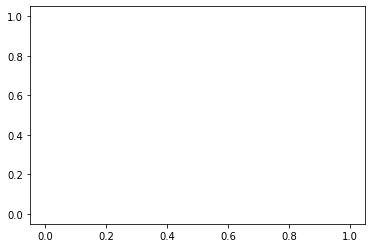

In [252]:
get_pred(t[mid],s[mid], 816)

In [251]:
next(iter(test_ds))

{'target': array([31.]),
 'feat': array([0., 1.]),
 'start': Timestamp('2019-01-01 00:00:00', freq='T'),
 'forecast_start': Timestamp('2019-01-01 00:00:00', freq='T')}

In [253]:
scaler

StandardScaler(copy=True, with_mean=True, with_std=True)

In [34]:
pm, mid = train_model(2,dropout = 0.1)
#t[mid],s[mid], e[mid] = eval_model(pm)
p[mid] = pm
#run_test(t[mid], s[mid], [31,816,846,856])

#mid = 'mlp-e2000-l10-10-5-student-d0.1'
save_model(p[mid], mid)

INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 135.25it/s, avg_epoch_loss=1.07]
INFO:root:Epoch[0] Elapsed time 0.742 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=1.072252
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 136.54it/s, avg_epoch_loss=0.516]
INFO:root:Epoch[1] Elapsed time 0.734 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.515619
INFO:root:Loading parameters from best epoch (1)
INFO:root:Final loss: 0.5156192578375339 (occurred at epoch 1)
INFO:root:End model training


### test pitmodel

In [58]:
_scaler = scaler

In [135]:
id = 'mlp-e2000-l10-10-5-student-d0.1'
t[id],s[id], e[id] = eval_model(p[id])

Running evaluation: 100%|██████████| 3638/3638 [00:17<00:00, 202.38it/s]

{
    "MSE": 0.14905110432579788,
    "abs_error": 1090.921557557438,
    "abs_target_sum": 3083.21469670675,
    "abs_target_mean": 0.8475026653949286,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.5593973087847123,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 509.9840140520008,
    "Coverage[0.1]": 0.22952171522814732,
    "QuantileLoss[0.5]": 1090.921557557438,
    "Coverage[0.5]": 0.6278174821330401,
    "QuantileLoss[0.9]": 566.985343087572,
    "Coverage[0.9]": 0.8507421660252886,
    "RMSE": 0.38607137206195163,
    "NRMSE": 0.45554000928368277,
    "ND": 0.3538260111184198,
    "wQuantileLoss[0.1]": 0.1654065850804117,
    "wQuantileLoss[0.5]": 0.3538260111184198,
    "wQuantileLoss[0.9]": 0.18389421394922048,
    "mean_wQuantileLoss": 0.234375603382684,
    "MAE_Coverage": 0.10219901044529961
}


In [140]:
forecasts = s[id]
tss = t[id]

scaler = _scaler
testset = test_sel[['lap2nextpit','caution_laps','pitage']].values

pitmodel = PitModel()

pitmodel.save_model('pitmodel_test', testset, forecasts, scaler)

save model pitmodel_test with 443 keys.


idx: 31 t: 31 p: 34
idx: 816 t: 44 p: 33
idx: 846 t: 14 p: 11
idx: 856 t: 4 p: 4


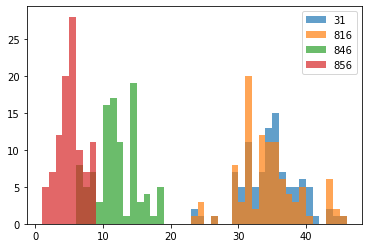

In [149]:
newcasts = pitmodel.forecast_ds(testset, forecasts)
scaler = _scaler
run_test(tss, newcasts, [31,816,846,856],raw_forecast=True)

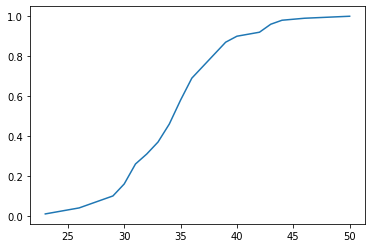

In [145]:
plt.plot(pitmodel.model['0-0'][0,:], pitmodel.model['0-0'][1,:])

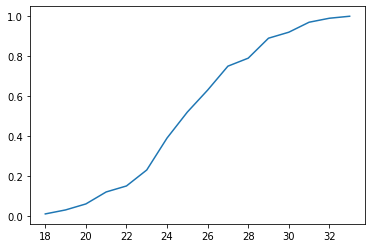

In [146]:
plt.plot(pitmodel.model['10-13'][0,:], pitmodel.model['10-13'][1,:])

In [147]:
pitmodel.model['0-0'][0,:]

array([23., 24., 26., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 46., 50.])

In [160]:
scaler = _scaler
test_all = df_test[['lap2nextpit','caution_laps','pitage']].values
test_ds, _, test_set = makedb(test_all, scaler, perm=False)

id = 'mlp-e2000-l10-10-5-student-d0.1'
t[id],s[id], e[id] = eval_model(p[id])
forecasts = s[id]
tss = t[id]

pitmodel = PitModel()

pitmodel.save_model(f'mlp-{id}.pickle', test_all, forecasts, scaler)


Running evaluation: 100%|██████████| 4920/4920 [00:24<00:00, 202.91it/s]

{
    "MSE": 0.5668742791319306,
    "abs_error": 2708.984744954919,
    "abs_target_sum": 4138.4803167592145,
    "abs_target_mean": 0.8411545359266696,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.9056031603272189,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 2261.3739085343464,
    "Coverage[0.1]": 0.2380081300813008,
    "QuantileLoss[0.5]": 2708.984744954919,
    "Coverage[0.5]": 0.3902439024390244,
    "QuantileLoss[0.9]": 1332.3295285652634,
    "Coverage[0.9]": 0.6928861788617886,
    "RMSE": 0.7529105385980001,
    "NRMSE": 0.8950918130264206,
    "ND": 0.6545844217222921,
    "wQuantileLoss[0.1]": 0.5464261601962134,
    "wQuantileLoss[0.5]": 0.6545844217222921,
    "wQuantileLoss[0.9]": 0.3219369011300728,
    "mean_wQuantileLoss": 0.5076491610161927,
    "MAE_Coverage": 0.15162601626016262
}
save model mlp-mlp-e2000-l10-10-5-student-d0.1.pickle with 485 keys.


In [159]:
len(forecasts)

3638

In [155]:
testall_set

array([[ 1.31631032, -0.66361824, -1.38905732],
       [ 1.223684  , -0.66361824, -1.29641709],
       [ 1.13105769, -0.66361824, -1.20377687],
       ...,
       [-1.27722653,  2.79892137,  2.40919189],
       [-1.36985285,  2.79892137,  2.50183212],
       [-1.46247916,  2.79892137,  2.59447234]])

In [165]:
scaler = _scaler
maxgap = 60
test_ds, _, test_set, test_all = make_fulltestdb(scaler, maxgap = maxgap)

id = 'mlp-e2000-l10-10-5-student-d0.1'

t[id],s[id], e[id] = eval_model(p[id])
forecasts = s[id]
tss = t[id]

pitmodel = PitModel()

pitmodel.save_model(f'pitmodel-m{maxgap}-{id}.pickle', test_all, forecasts, scaler)

Running evaluation: 100%|██████████| 1830/1830 [00:08<00:00, 205.69it/s]


{
    "MSE": 0.8062794462294298,
    "abs_error": 1232.356544515164,
    "abs_target_sum": 2845.843026205015,
    "abs_target_mean": 1.5551054788005547,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.5730178105567554,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 1216.5818836204064,
    "Coverage[0.1]": 0.4644808743169399,
    "QuantileLoss[0.5]": 1232.356544515164,
    "Coverage[0.5]": 0.5825136612021858,
    "QuantileLoss[0.9]": 651.5813609212005,
    "Coverage[0.9]": 0.6721311475409836,
    "RMSE": 0.8979306466701256,
    "NRMSE": 0.5774081944349493,
    "ND": 0.433037427984401,
    "wQuantileLoss[0.1]": 0.42749437422159614,
    "wQuantileLoss[0.5]": 0.433037427984401,
    "wQuantileLoss[0.9]": 0.2289589956021209,
    "mean_wQuantileLoss": 0.3631635992693727,
    "MAE_Coverage": 0.2249544626593807
}
save model pitmodel-m60-mlp-e2000-l10-10-5-student-d0.1.pickle with 1830 keys.


In [166]:
pitmodel.model['0-0'][0,:]

array([20., 21., 23., 25., 26., 27., 28., 29., 30., 31., 32., 33., 34.,
       35., 36., 37., 38.])

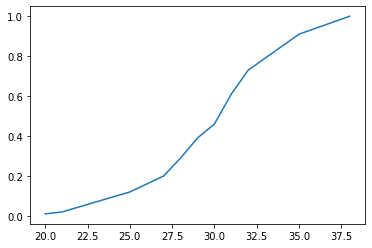

In [167]:
plt.plot(pitmodel.model['0-0'][0,:], pitmodel.model['0-0'][1,:])

In [41]:
t.keys()

dict_keys(['mlp-e500-l10-10-5-student-d0.1', 'mlp-dsel-e500-l10-10-5-student-d0.1'])

In [45]:
t['mlp-dsel-e500-l10-10-5-student-d0.1'][0]

,0
2019-01-01,1.642726
